# Anomaly detection in the CPEs

In this notebook we are going to use Historical data from the `DSL` line, `WiFi`, `DSLAM` info to detect the anomaly in `CPE`

**Bussiness impact:**
DT wants to know about the CPEs which has some abnormalities and problem can be resolved in prior customer reporting an issue

**Key insights:**
By setting thresholds specific for each CPE type, anomalies clearly detect the outliers by using AutoEncoder.





<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CPE-Replacement-Prediction" data-toc-modified-id="CPE-Replacement-Prediction-1"><code>CPE</code> Replacement Prediction</a></span><ul class="toc-item"><li><span><a href="#Basic-libraries" data-toc-modified-id="Basic-libraries-1.1">Basic libraries</a></span></li><li><span><a href="#Let's-setup-some-style!" data-toc-modified-id="Let's-setup-some-style!-1.2">Let's setup some style!</a></span></li></ul></li><li><span><a href="#1.-Data-gathering-and-feature-engineering" data-toc-modified-id="1.-Data-gathering-and-feature-engineering-2">1. Data gathering and feature engineering</a></span><ul class="toc-item"><li><span><a href="#1.1-Data-gather-from-HDFS-using-Window-and-Gap" data-toc-modified-id="1.1-Data-gather-from-HDFS-using-Window-and-Gap-2.1">1.1 Data gather from HDFS using Window and Gap</a></span><ul class="toc-item"><li><span><a href="#Check-Correlation-of-Categorical-variables" data-toc-modified-id="Check-Correlation-of-Categorical-variables-2.1.1">Check Correlation of Categorical variables</a></span></li><li><span><a href="#Create-Categorical-dataset" data-toc-modified-id="Create-Categorical-dataset-2.1.2">Create Categorical dataset</a></span></li></ul></li><li><span><a href="#1.3-Preprocessing-and-Feature-Engineering" data-toc-modified-id="1.3-Preprocessing-and-Feature-Engineering-2.2">1.3 Preprocessing and Feature Engineering</a></span></li></ul></li><li><span><a href="#2.-Train-Model-Base-Line" data-toc-modified-id="2.-Train-Model-Base-Line-3">2. Train Model Base Line</a></span></li><li><span><a href="#Convolutional-NeuralNet-for-Time-series" data-toc-modified-id="Convolutional-NeuralNet-for-Time-series-4">Convolutional NeuralNet for Time series</a></span></li><li><span><a href="#Max-Min-Scaler-per-CPE-Type" data-toc-modified-id="Max-Min-Scaler-per-CPE-Type-5">Max Min Scaler per <code>CPE Type</code></a></span></li><li><span><a href="#Encoder" data-toc-modified-id="Encoder-6">Encoder</a></span></li><li><span><a href="#Decoder" data-toc-modified-id="Decoder-7">Decoder</a></span></li><li><span><a href="#AutoEncoder" data-toc-modified-id="AutoEncoder-8">AutoEncoder</a></span></li><li><span><a href="#LightningDataModule" data-toc-modified-id="LightningDataModule-9"><code>LightningDataModule</code></a></span></li><li><span><a href="#TensorBoard-Experiment-Logs" data-toc-modified-id="TensorBoard-Experiment-Logs-10"><code>TensorBoard</code> Experiment Logs</a></span><ul class="toc-item"><li><span><a href="#Check-Autoencoder" data-toc-modified-id="Check-Autoencoder-10.1">Check Autoencoder</a></span></li><li><span><a href="#Test-data-Analysis" data-toc-modified-id="Test-data-Analysis-10.2">Test data Analysis</a></span></li></ul></li><li><span><a href="#Classifier-Stage" data-toc-modified-id="Classifier-Stage-11">Classifier Stage</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#TEST-Dataset-Results" data-toc-modified-id="TEST-Dataset-Results-11.0.1">TEST Dataset Results</a></span></li><li><span><a href="#Train-dataset-Results" data-toc-modified-id="Train-dataset-Results-11.0.2">Train dataset Results</a></span></li></ul></li></ul></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-12">Appendix</a></span><ul class="toc-item"><li><span><a href="#A.-Debuging" data-toc-modified-id="A.-Debuging-12.1">A. Debuging</a></span></li></ul></li><li><span><a href="#B.-Optimal-learning-rate" data-toc-modified-id="B.-Optimal-learning-rate-13">B. Optimal learning rate</a></span></li></ul></div>

## Basic libraries

In [3]:
# Data Science Packages
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  matplotlib import pyplot
import seaborn as sns
import warnings
from tqdm import tqdm, tqdm_notebook

## Let's setup some style!

This is not a requirement but anyway you know that they say:
> "Fashions fade, style is eternal." <br/>
_Yves Saint Laurent_

In [4]:
# Seaborn Style
sns.set(style='ticks')
sns.set_style({'font.family': 'Hiragino Maru Gothic Pro'})
sns.set_palette("cool")

# Pandas Style
pd.set_option("display.max_column", 9999)
pd.set_option("display.max_row", 9999)

# Ignore annoying warning 
warnings.filterwarnings('ignore')

# 1. Data gathering and feature engineering

In [397]:
import ipyplot
ipyplot.plot_images(['../data/external/images/diag1.png'], ['FLow Diagram'], img_width=1300)

## 1.1 Data gather from HDFS using Window and Gap

Load data for training but first we are going to load the parquet file and save it as csv due on order to cast the field type (some issues between how spark and pandas handle parquet files)

Let' take a look training and testing data

In [583]:
df_train = pd.read_parquet("../data/raw/df_train_n.parquet", engine='pyarrow')
print(df_train.shape)
df_train.head()

(372870, 137)


,assetid,CPE_SERIAL_NUMBER,TICKET_ID,ASSET_ID,TICKET_TENTATIVE_ROOT_CAUSE,START_DATE_TICKET,DATE_SCAN_START,DATE_SCAN_END,CPE_ISSUE,WINDOW_END,WINDOW_START,dslam_distinct_modulation,dslam_no_of_dominant_modulation,dslam_code_of_dominant_modulation,dslam_avg_bitrate_us,dslam_avg_bitrate_ds,dslam_avg_attenuation_ds,dslam_avg_attenuation_us,dslam_avg_power_us,dslam_avg_power_ds,dslam_avg_att_bitrate_us,dslam_avg_att_bitrate_ds,dslam_avg_snr_us,dslam_avg_snr_ds,dslam_no_counts,dslam_avg_bandline_ds,dslam_avg_bandline_us,dslam_sum_cv_us,dslam_count_cv_us,dslam_sum_cv_ds,dslam_count_cv_ds,dslam_sum_es_ds,dslam_count_es_ds,dslam_sum_es_us,dslam_count_es_us,dslam_sum_ses_ds,dslam_count_ses_ds,dslam_sum_ses_us,dslam_count_ses_us,dslam_sum_fec_ds,dslam_count_fec_ds,dslam_sum_fec_us,dslam_count_fec_us,dslam_inits,dslam_port_inst_id,dslam_rg_port_inst_id,dslam_prim_izvod_inst_id,snmp_no_lossoflink,snmp_no_linkup,snmp_no_dyinggasp,acs_xdslline_dslUptime,acs_xdslline_cpeUptime,acs_xdslline_cpuUsagePercentage,acs_xdslline_freeMemoryKb,acs_xdslline_totalMemoryKb,acs_xdslline_usedMemoryKb,acs_xdslline_natCurrent,acs_xdslline_natMax,acs_xdslline_crc,acs_xdslline_fec,acs_xdslline_hec,acs_xdslline_cellDelin,acs_xdslline_erroredSecs,acs_xdslline_initErrors,acs_xdslline_initTimeOuts,acs_xdslline_severelyErroredSecs,acs_xdslline_linkRetrain,acs_xdslline_lossOfFraming,acs_xdslline_lossOfPower,acs_xdslline_transmitBlocks,acs_xdslline_receiveBlocks,acs_xdslline_downAttenuationDb,acs_xdslline_downCurrRateKbps,acs_xdslline_downMaxRateKbps,acs_xdslline_downNoiseMarginDb,acs_xdslline_downPowerDbm,acs_xdslline_upAttenuationDb,acs_xdslline_upCurrRateKbps,acs_xdslline_upMaxRateKbps,acs_xdslline_upNoiseMarginDb,acs_xdslline_upPowerDbm,acs_xdslline_atuccrc,acs_xdslline_atucfec,acs_xdslline_atuchec,datum,dslam_date_inserted,dslam_platforma,dslam_model,dslam_card_type,dslam_status_porta,dslam_bandwidth,dslam_vdsl_adsl,dslam_vendor,dslam_status,dslam_internet,dslam_iptv,dslam_voip,dslam_regija,acs_@type,acs_status,acs_description,acs_crm_accessNetwork,acs_crm_dslamFrame,acs_crm_dslamSlot,acs_crm_serviceName,cpetype,acs_xdslline_manufacturer,acs_xdslline_manufacturerOui,acs_xdslline_softwareVersion,acs_xdslline_additionalSoftwareVersion,acs_xdslline_anexType,acs_xdslline_dslType,acs_xdslline_linkEncapsulationType,acs_xdslline_pppoEConnectionStatus,acs_xdslline_pppoELastConnectionError,acs_xdslline_pppoENATEnabled,acs_xdslline_pppoEUsername,acs_createdmsec,label_internet_not_working,label_optical_port,label_reset_not_work,label_sim_slot,label_no_problem,label_healthy,label_reset_itself,label_wifi,label_significant_physical_damage_irreparable,label_lan_port,label_telefon_port,label_blocked,label_device_overheating,label_poor_speed,label_does_not_log_into_acs,label_software,label_dsl_port,label_minor_physical_thermal_damage,label_power_supply
0,29035788,None,NaN,NaN,None,None,None,None,healthy,None,None,1.0,21.0,3.0,391.0,520.0,26.300000,17.1,-11.284211,1.3,1338.150000,11025.714286,11.980000,22.221053,19.0,NaN,NaN,0.0,29.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59299498.0,23043919.0,393732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-13 22:00:00,2020-08-15 02:15:12.239394,ERICSSON EDA,EDA MEDIUM SUBRACK,EDN312XI,Dobar,ADSL BB,ADSL,ERICSSON,Dobar,N,N,Y,4 - ISTOK,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33201629,None,NaN,NaN,None,None,None,None,healthy,None,None,1.0,22.0,6.0,3247.0,25434.0,20.200000,8.2,6.900000,18.8,5389.347826,31516.000000,11.718182,9.695455,22.0,202.0,82.0,6.0,4.0,30.0,7.0,10.0,7.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73479220.0,10692023.0,370061.0,NaN,NaN,NaN,172823.0,172950.0,1.0,11960.0,81460.0,69500.0,109.0,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,25434.0,31516.0,NaN,18.0,18.0,3247.0,558

In [584]:
#Filter out only healthy cpes from the training data
df_train = df_train.loc[df_train.CPE_ISSUE=='healthy']
print('Resultant Training dataset size:',df_train.shape)

Resultant Training dataset size: (270240, 137)


In [585]:
df_train['label_healthy'].value_counts()

1    270240
Name: label_healthy, dtype: int64

In [586]:
df_train['CPE_ISSUE'].value_counts()

healthy    270240
Name: CPE_ISSUE, dtype: int64

In [587]:
print('Percentage Distribution of CPEs in training set: \n')
fmt = '{:.2%}'.format
print((df_train.drop_duplicates('assetid').cpetype.value_counts()/df_train.drop_duplicates('assetid').shape[0]).map(fmt))

Percentage Distribution of CPEs in training set: 

HA35-11              13.83%
Speedport Plus181    12.27%
W724Ci               10.16%
W724Ci_11AC           8.88%
ZXDSL 931VII V4.0     8.38%
ZXDSL931VII           5.81%
Speedport Plus        0.80%
FRITZ!Box_6890        0.02%
FRITZ!Box_7590        0.01%
Name: cpetype, dtype: object


In [588]:
df_test = pd.read_parquet("../data/raw/df_test_n.parquet", engine='pyarrow')
print(df_test.shape)
df_test.head()

(40920, 137)


,assetid,CPE_SERIAL_NUMBER,TICKET_ID,ASSET_ID,TICKET_TENTATIVE_ROOT_CAUSE,START_DATE_TICKET,DATE_SCAN_START,DATE_SCAN_END,CPE_ISSUE,WINDOW_END,WINDOW_START,dslam_distinct_modulation,dslam_no_of_dominant_modulation,dslam_code_of_dominant_modulation,dslam_avg_bitrate_us,dslam_avg_bitrate_ds,dslam_avg_attenuation_ds,dslam_avg_attenuation_us,dslam_avg_power_us,dslam_avg_power_ds,dslam_avg_att_bitrate_us,dslam_avg_att_bitrate_ds,dslam_avg_snr_us,dslam_avg_snr_ds,dslam_no_counts,dslam_avg_bandline_ds,dslam_avg_bandline_us,dslam_sum_cv_us,dslam_count_cv_us,dslam_sum_cv_ds,dslam_count_cv_ds,dslam_sum_es_ds,dslam_count_es_ds,dslam_sum_es_us,dslam_count_es_us,dslam_sum_ses_ds,dslam_count_ses_ds,dslam_sum_ses_us,dslam_count_ses_us,dslam_sum_fec_ds,dslam_count_fec_ds,dslam_sum_fec_us,dslam_count_fec_us,dslam_inits,dslam_port_inst_id,dslam_rg_port_inst_id,dslam_prim_izvod_inst_id,snmp_no_lossoflink,snmp_no_linkup,snmp_no_dyinggasp,acs_xdslline_dslUptime,acs_xdslline_cpeUptime,acs_xdslline_cpuUsagePercentage,acs_xdslline_freeMemoryKb,acs_xdslline_totalMemoryKb,acs_xdslline_usedMemoryKb,acs_xdslline_natCurrent,acs_xdslline_natMax,acs_xdslline_crc,acs_xdslline_fec,acs_xdslline_hec,acs_xdslline_cellDelin,acs_xdslline_erroredSecs,acs_xdslline_initErrors,acs_xdslline_initTimeOuts,acs_xdslline_severelyErroredSecs,acs_xdslline_linkRetrain,acs_xdslline_lossOfFraming,acs_xdslline_lossOfPower,acs_xdslline_transmitBlocks,acs_xdslline_receiveBlocks,acs_xdslline_downAttenuationDb,acs_xdslline_downCurrRateKbps,acs_xdslline_downMaxRateKbps,acs_xdslline_downNoiseMarginDb,acs_xdslline_downPowerDbm,acs_xdslline_upAttenuationDb,acs_xdslline_upCurrRateKbps,acs_xdslline_upMaxRateKbps,acs_xdslline_upNoiseMarginDb,acs_xdslline_upPowerDbm,acs_xdslline_atuccrc,acs_xdslline_atucfec,acs_xdslline_atuchec,datum,dslam_date_inserted,dslam_platforma,dslam_model,dslam_card_type,dslam_status_porta,dslam_bandwidth,dslam_vdsl_adsl,dslam_vendor,dslam_status,dslam_internet,dslam_iptv,dslam_voip,dslam_regija,acs_@type,acs_status,acs_description,acs_crm_accessNetwork,acs_crm_dslamFrame,acs_crm_dslamSlot,acs_crm_serviceName,cpetype,acs_xdslline_manufacturer,acs_xdslline_manufacturerOui,acs_xdslline_softwareVersion,acs_xdslline_additionalSoftwareVersion,acs_xdslline_anexType,acs_xdslline_dslType,acs_xdslline_linkEncapsulationType,acs_xdslline_pppoEConnectionStatus,acs_xdslline_pppoELastConnectionError,acs_xdslline_pppoENATEnabled,acs_xdslline_pppoEUsername,acs_createdmsec,label_internet_not_working,label_optical_port,label_reset_not_work,label_sim_slot,label_no_problem,label_healthy,label_reset_itself,label_wifi,label_significant_physical_damage_irreparable,label_lan_port,label_telefon_port,label_blocked,label_device_overheating,label_poor_speed,label_does_not_log_into_acs,label_software,label_dsl_port,label_minor_physical_thermal_damage,label_power_supply
0,49484053,None,NaN,NaN,None,None,None,None,healthy,None,None,1.0,23.0,9.0,1525.0,7537.000000,23.100000,15.900000,6.900000,4.62381,2828.904762,9848.000000,8.014286,8.254545,23.0,231.000000,159.0,2.0,2.0,1151.0,6.0,118.0,8.0,2.0,2.0,20.0,2.0,0.0,0.0,4428.0,27.0,666.0,17.0,0.0,81250272.0,81042299.0,9116481.0,NaN,NaN,NaN,40633.0,1382645.0,1.0,11544.0,81460.0,69916.0,29.0,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,8272.0,9848.0,NaN,2.0,26.0,1695.0,2608.0,NaN,6.0,3035.0,287641.0,NaN,2020-08-12 22:00:00,2020-08-14 02:15:15.040204,HUAWEI SMARTAX,MA5603T,VCPM,Dobar,ADSL BB,VDSL,HUAWEI,Dobar,Y,N,Y,1 - SJEVER,AcsCollXdsl,SUCCESS,None,VDSL,0,0,ADSL Internet + ResidentVoIP,Speedport Plus181,Sercomm,00C002,09022001.00.030_HT,None,G.993.2_Annex_B,None,N/A,Connected,N/A,None,jfili632@htnet-dsl,1597319517968,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,75308132,None,NaN,NaN,None,None,None,None,healthy,None,None,1.0,19.0,6.0,4256.0,27069.857143,21.738095,12.600000,7.376190,18.60000,5552.150000,28826.136364,7.280000,8.233333,21.0,244.285714,126.0,94.0,24.0,8.0,3.0,2.0,2.0,100.0,28.0,0.0,0.0,0.0,0.0,3160.0,19.0,648.0,1.0,0.0,7664944

In [589]:
print('Percentage Distribution of CPEs in testing set: \n')
fmt = '{:.2%}'.format
print((df_test.drop_duplicates('assetid').cpetype.value_counts()/df_test.drop_duplicates('assetid').shape[0]).map(fmt))

Percentage Distribution of CPEs in testing set: 

HA35-11              14.81%
W724Ci               13.05%
Speedport Plus181    11.58%
W724Ci_11AC          10.19%
ZXDSL 931VII V4.0     5.94%
ZXDSL931VII           3.96%
Speedport Plus        0.66%
Name: cpetype, dtype: object


In [590]:
df_train = df_train[df_train.cpetype.isin(['HA35-11','Speedport Plus181','W724Ci','W724Ci_11AC','ZXDSL 931VII V4.0','ZXDSL931VII'])]
df_test = df_test[df_test.cpetype.isin(['HA35-11','Speedport Plus181','W724Ci','W724Ci_11AC','ZXDSL 931VII V4.0','ZXDSL931VII'])]
print('Training set size: ',df_train.shape)
print('Testing set size:',df_test.shape)

Training set size:  (119362, 137)
Testing set size: (19412, 137)


In [591]:
labels = list(df_train.filter(regex='label'))
print(len(labels))
labels

19


['label_internet_not_working',
 'label_optical_port',
 'label_reset_not_work',
 'label_sim_slot',
 'label_no_problem',
 'label_healthy',
 'label_reset_itself',
 'label_wifi',
 'label_significant_physical_damage_irreparable',
 'label_lan_port',
 'label_telefon_port',
 'label_blocked',
 'label_device_overheating',
 'label_poor_speed',
 'label_does_not_log_into_acs',
 'label_software',
 'label_dsl_port',
 'label_minor_physical_thermal_damage',
 'label_power_supply']

In [592]:
id_cols = list(df_train.filter(regex='id'))
print(id_cols)
id_cols.remove('dslam_bandwidth')
id_cols.remove('assetid')
id_cols

['assetid', 'dslam_port_inst_id', 'dslam_rg_port_inst_id', 'dslam_prim_izvod_inst_id', 'dslam_bandwidth']


['dslam_port_inst_id', 'dslam_rg_port_inst_id', 'dslam_prim_izvod_inst_id']

In [62]:
def impute_date(df,start_dt_col,end_dt_col):
    '''
    This function impute the date for 2 specific columns 
    
    Args:
        df: dataframe
        start_dt_col: Column with Start date
        end_dt_col: Column with end date
        
    Results:
        Pandas dataframe
    
    '''
    min_date = df.loc[df.label_healthy==1]['datum'].min()
    max_date = df.loc[df.label_healthy==1]['datum'].max()
    df[start_dt_col].fillna(min_date,inplace=True)
    df[end_dt_col].fillna(max_date,inplace=True)

In [593]:
impute_date(df_train,'WINDOW_START','WINDOW_END')
impute_date(df_test,'WINDOW_START','WINDOW_END')

In [150]:
#impute_date(no_split,'WINDOW_START','WINDOW_END')

In [576]:
#Dropping Unnecessarry columns
#no_split.drop(labels + id_cols,axis=1,inplace=True)
df_train.drop(labels + id_cols,axis=1,inplace=True)
df_test.drop(labels + id_cols,axis=1,inplace=True)

In [594]:
df_train.drop_duplicates(subset=['assetid']).groupby(['cpetype'])['cpetype'].describe()

,count,unique,top,freq
cpetype,,,,
HA35-11,1369,1,HA35-11,1369
Speedport Plus181,1238,1,Speedport Plus181,1238
W724Ci,993,1,W724Ci,993
W724Ci_11AC,923,1,W724Ci_11AC,923
ZXDSL 931VII V4.0,772,1,ZXDSL 931VII V4.0,772
ZXDSL931VII,539,1,ZXDSL931VII,539


In [595]:
df_test.drop_duplicates(subset=['assetid']).groupby(['cpetype'])['cpetype'].describe()

,count,unique,top,freq
cpetype,,,,
HA35-11,240,1,HA35-11,240
Speedport Plus181,201,1,Speedport Plus181,201
W724Ci,220,1,W724Ci,220
W724Ci_11AC,194,1,W724Ci_11AC,194
ZXDSL 931VII V4.0,87,1,ZXDSL 931VII V4.0,87
ZXDSL931VII,55,1,ZXDSL931VII,55


## 1.2 Check Correlation of Categorical variables

In [73]:
def identify_vars_type(df):
    '''
    This function provide the nuumber of numeric and categorical variables
    
    Args:
        df (dataframe) : dataframe we are using
    
    Returns:
        list(str) : All the avilable vars of different datatype
    '''
    
    timestamp_var = list(df[0:1].select_dtypes(include=['datetime64']).columns.values)
    numeric_var=list(df[0:1].select_dtypes(include=['int64','float64','float32']).columns.values)
    cat_var=list(df[0:1].select_dtypes(include=['object']).columns.values)
    return timestamp_var,numeric_var,cat_var

In [74]:
timestamp_var,numeric_var,cat_var = identify_vars_type(df_train)

In [124]:
def df_investigate(df):
    '''
    This function provide the nuumber of numeric and categorical variables
    
    Args:
        df (dataframe) : dataframe we are using
    
    Returns:
        df(dataframe) : dataframe 
    '''    
    
    info = pd.DataFrame(df.count(), columns=['filled'])
    #info['filled %'] = round(info['filled'] / len(df), 4)*100
    info['null%'] = round(df.isnull().sum()/len(df), 4)*100
    info['no_categories'] = df.nunique()
    info['categories'] = np.nan
    info['dtypes'] = df.dtypes
    for idx, row in info.iterrows():
        if row['no_categories'] < 20:
            info.loc[idx, 'categories'] = str(list(df[idx].unique()))
    return info

In [596]:
df_investigate(df_train).sort_values('null%',ascending=False)

,filled,null%,no_categories,categories,dtypes
acs_xdslline_lossOfPower,0,100.00,0,[nan],float64
START_DATE_TICKET,0,100.00,0,[None],object
DATE_SCAN_END,0,100.00,0,[None],object
DATE_SCAN_START,0,100.00,0,[None],object
CPE_SERIAL_NUMBER,0,100.00,0,[None],object
TICKET_TENTATIVE_ROOT_CAUSE,0,100.00,0,[None],object
TICKET_ID,0,100.00,0,[nan],float64
ASSET_ID,0,100.00,0,[nan],float64
acs_description,1157,99.03,3,"[None, 'Could not connect', 'Could not retriev...",object
snmp_no_lossoflink,10132,91.51,80,NaN,float64


In [75]:
cat_var

['assetid',
 'CPE_SERIAL_NUMBER',
 'TICKET_TENTATIVE_ROOT_CAUSE',
 'START_DATE_TICKET',
 'DATE_SCAN_START',
 'DATE_SCAN_END',
 'CPE_ISSUE',
 'dslam_platforma',
 'dslam_model',
 'dslam_card_type',
 'dslam_status_porta',
 'dslam_bandwidth',
 'dslam_vdsl_adsl',
 'dslam_vendor',
 'dslam_status',
 'dslam_internet',
 'dslam_iptv',
 'dslam_voip',
 'dslam_regija',
 'acs_@type',
 'acs_status',
 'acs_description',
 'acs_crm_accessNetwork',
 'acs_crm_dslamFrame',
 'acs_crm_dslamSlot',
 'acs_crm_serviceName',
 'cpetype',
 'acs_xdslline_manufacturer',
 'acs_xdslline_manufacturerOui',
 'acs_xdslline_softwareVersion',
 'acs_xdslline_additionalSoftwareVersion',
 'acs_xdslline_anexType',
 'acs_xdslline_dslType',
 'acs_xdslline_linkEncapsulationType',
 'acs_xdslline_pppoEConnectionStatus',
 'acs_xdslline_pppoELastConnectionError',
 'acs_xdslline_pppoENATEnabled',
 'acs_xdslline_pppoEUsername',
 'acs_createdmsec']

In [86]:
remove = ['assetid',
 'CPE_SERIAL_NUMBER',
 'TICKET_TENTATIVE_ROOT_CAUSE',
 'START_DATE_TICKET',
 'DATE_SCAN_START',
 'DATE_SCAN_END']

In [87]:
cat_var_2 = list(set(cat_var)-set(remove))

Deal with Categorical variables

In [101]:
import scipy.stats as ss
import itertools

In [102]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [106]:
def cat_corr(df,cat_cols):
    cols = cat_cols
    corrM = np.zeros((len(cols),len(cols)))
    # there's probably a nice pandas way to do this
    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
        corrM[idx2, idx1] = corrM[idx1, idx2]
    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    return corr

In [107]:
cat_corr_df = cat_corr(df_train,cat_var_2)

Text(0.5, 1.0, 'Cramer V Correlation between Variables')

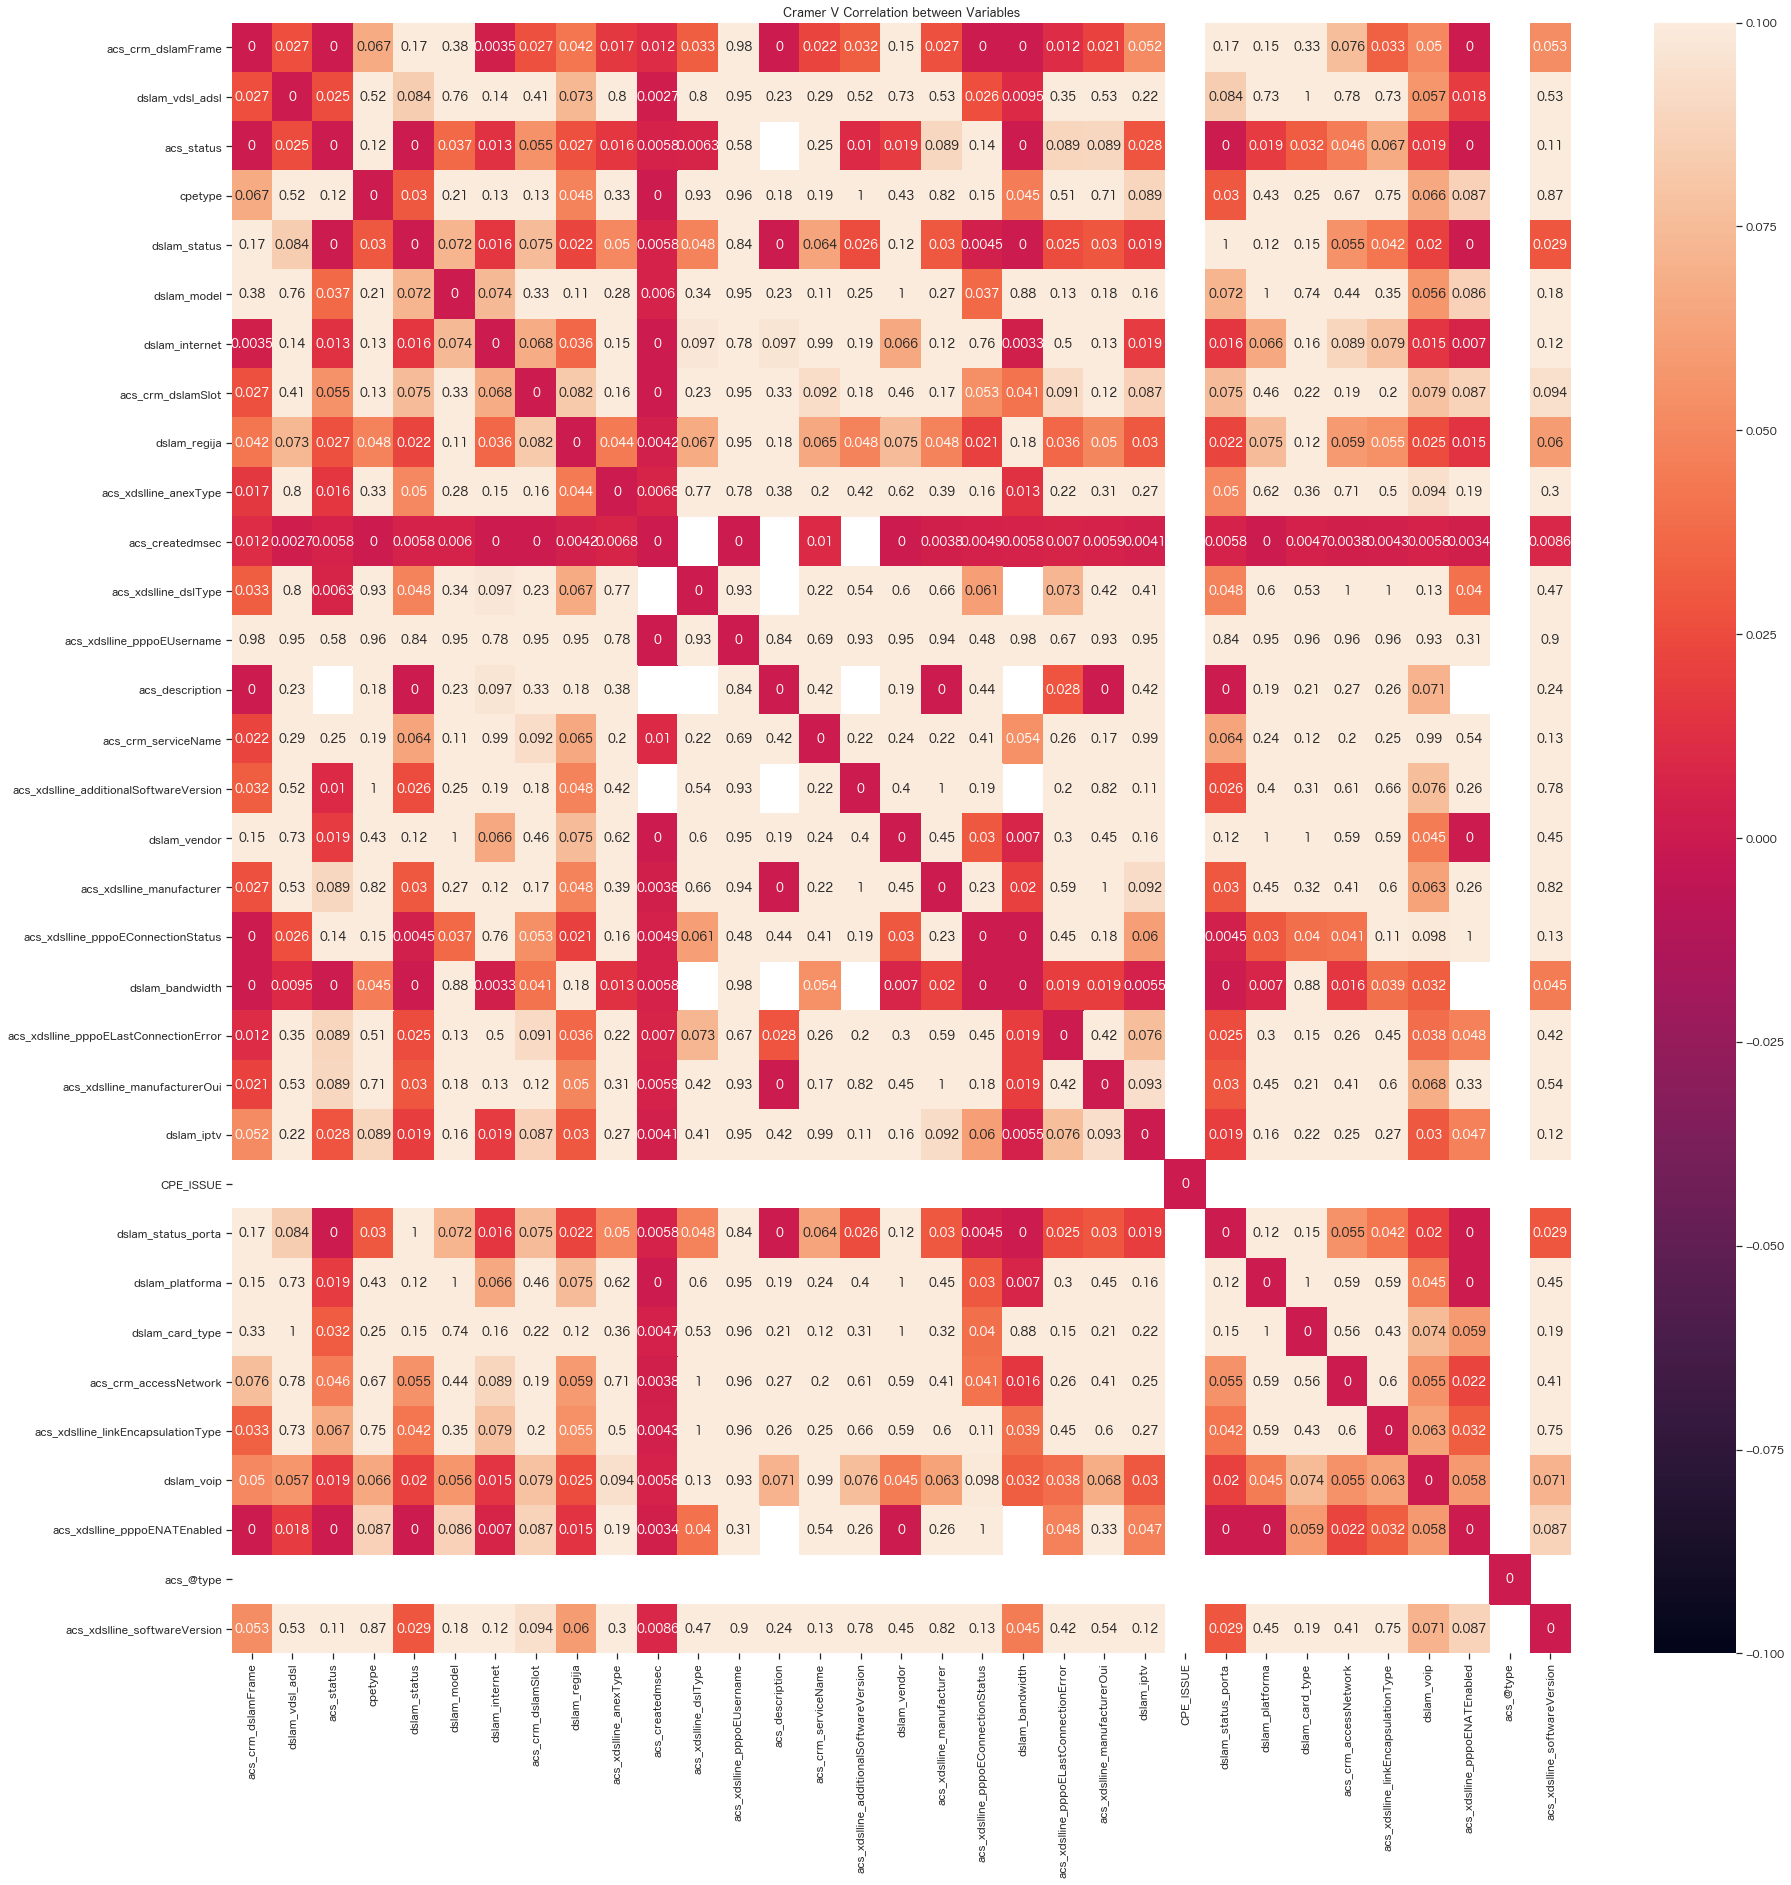

In [115]:
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(cat_corr_df, annot=True, ax=ax)
ax.set_title("Cramer V Correlation between Variables")

In [119]:
def drop_cat_fts(corr_matrix):
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.85)]
    return to_drop

In [120]:
to_drop= drop_cat_fts(cat_corr_df)
to_drop

['acs_xdslline_dslType',
 'acs_xdslline_pppoEUsername',
 'acs_description',
 'acs_crm_serviceName',
 'acs_xdslline_additionalSoftwareVersion',
 'dslam_vendor',
 'acs_xdslline_manufacturer',
 'dslam_bandwidth',
 'acs_xdslline_manufacturerOui',
 'dslam_iptv',
 'dslam_status_porta',
 'dslam_platforma',
 'dslam_card_type',
 'acs_crm_accessNetwork',
 'acs_xdslline_linkEncapsulationType',
 'dslam_voip',
 'acs_xdslline_pppoENATEnabled',
 'acs_xdslline_softwareVersion']

In [121]:
to_drop.remove('acs_crm_accessNetwork')

In [129]:
retained_vars = list(set(cat_var)-set(to_drop))
retained_vars

['acs_crm_dslamFrame',
 'dslam_vdsl_adsl',
 'acs_status',
 'cpetype',
 'dslam_status',
 'dslam_model',
 'dslam_internet',
 'acs_crm_dslamSlot',
 'CPE_SERIAL_NUMBER',
 'dslam_regija',
 'acs_xdslline_anexType',
 'acs_createdmsec',
 'acs_xdslline_pppoEConnectionStatus',
 'acs_xdslline_pppoELastConnectionError',
 'START_DATE_TICKET',
 'DATE_SCAN_END',
 'TICKET_TENTATIVE_ROOT_CAUSE',
 'CPE_ISSUE',
 'assetid',
 'DATE_SCAN_START',
 'acs_crm_accessNetwork',
 'acs_@type']

In [62]:
new_list=[ 'acs_@type',
 'dslam_platforma',
 'acs_xdslline_pppoEConnectionStatus',
 'dslam_internet',
 'dslam_regija',
 'cpetype',
 'acs_crm_dslamFrame',
 'acs_xdslline_manufacturer',
 'CPE_ISSUE',
 'acs_status',
 'acs_crm_accessNetwork',
 'dslam_voip',
 'dslam_status_porta',
 'dslam_iptv',
 'acs_crm_dslamSlot',
 'datum',
 'dslam_bandwidth',
 'acs_xdslline_pppoENATEnabled',
 'acs_description',
 'acs_xdslline_pppoELastConnectionError']

In [140]:
df_train.acs_xdslline_pppoEConnectionStatus.value_counts()/df_train.shape[0]

Connected         0.373661
Disconnected      0.020812
Connecting        0.004598
N/A               0.000611
AccountFail       0.000357
Authenticating    0.000074
Disconnecting     0.000034
Name: acs_xdslline_pppoEConnectionStatus, dtype: float64

In [30]:
df_train.acs_xdslline_pppoEConnectionStatus.isnull().sum()/df_train.shape[0]

0.45825403231478185

In [445]:
# for i in new_list:
#     if df_train[i].nunique()<20:
#         print(no_split[i].value_counts()/no_split.shape[0])
#         print('\n')

### 1.3 Create Categorical dataset 

In [597]:
features_category = ['acs_crm_accessNetwork','dslam_iptv','dslam_model','dslam_regija','cpetype']

In [598]:
def pipeline_categorical(df, features_category):
    """Defines the pipeline for preporcess columns with measures.
    
    Args:
        df (dataframe): Input dataframe.
        features_measures (list[str]): List of target features. 
    
    Returns:
        dataframe: Output with selected columns
        
    """
    
    df_categorical = df[['assetid'] +features_category]
    df_categorical = df_categorical.fillna(0)
    df_categorical = pd.get_dummies(df_categorical, columns=features_category)
    df_categorical = df_categorical.drop_duplicates('assetid')
    return df_categorical

In [599]:
df_categorical = pipeline_categorical(df_train, features_category)
print(df_categorical.shape)
df_categorical.head()

(5834, 29)


,assetid,acs_crm_accessNetwork_ADSL,acs_crm_accessNetwork_ETH,acs_crm_accessNetwork_UNKNOWN,acs_crm_accessNetwork_VDSL,dslam_iptv_0,dslam_iptv_N,dslam_iptv_Y,dslam_model_0,dslam_model_EDA MEDIUM SUBRACK,dslam_model_EDA SMALL SUBRACK,dslam_model_EDA VDSL SUBRACK,dslam_model_MA5600T,dslam_model_MA5603T,dslam_model_MA5608T,dslam_model_MA5622A,dslam_model_MA5623A,dslam_regija_0,dslam_regija_1 - SJEVER,dslam_regija_2 - JUG,dslam_regija_3 - ZAPAD,dslam_regija_4 - ISTOK,dslam_regija_null,cpetype_HA35-11,cpetype_Speedport Plus181,cpetype_W724Ci,cpetype_W724Ci_11AC,cpetype_ZXDSL 931VII V4.0,cpetype_ZXDSL931VII
1,33201629,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,35830246,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,37412872,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,40646183,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5,40865643,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


> In the above dataset we have the problem of Homoscedasticity where more than 1 variable tells us the same information. So it's always good to drop any cateogircal dummy variable from the each feature. So let's make a list of the variables which should get drop.

In [161]:
fts_to_drop=['acs_crm_accessNetwork_UNKNOWN','dslam_iptv_0','dslam_model_0','dslam_regija_0','cpetype_ZXDSL931VII']

In [163]:
df_categorical.drop(fts_to_drop,axis=1,inplace=True)

In [164]:
cat_order_cols = list(df_categorical.columns)

In [166]:
print(cat_order_cols)

['assetid', 'acs_crm_accessNetwork_ADSL', 'acs_crm_accessNetwork_ETH', 'acs_crm_accessNetwork_VDSL', 'dslam_iptv_N', 'dslam_iptv_Y', 'dslam_model_EDA MEDIUM SUBRACK', 'dslam_model_EDA SMALL SUBRACK', 'dslam_model_EDA VDSL SUBRACK', 'dslam_model_MA5600T', 'dslam_model_MA5603T', 'dslam_model_MA5608T', 'dslam_model_MA5622A', 'dslam_model_MA5623A', 'dslam_regija_1 - SJEVER', 'dslam_regija_2 - JUG', 'dslam_regija_3 - ZAPAD', 'dslam_regija_4 - ISTOK', 'dslam_regija_null', 'cpetype_HA35-11', 'cpetype_Speedport Plus181', 'cpetype_W724Ci', 'cpetype_W724Ci_11AC', 'cpetype_ZXDSL 931VII V4.0']


In [600]:
df_train.to_csv("../data/interim/df_train_2.csv",index=False)

In [288]:
df_test.to_csv("../data/interim/df_test_2.csv",index=False)

## 2. Preprocessing and Feature Engineering

In [269]:
def pipeline_categorical(df, features_category):
    """Defines the pipeline for preporcess columns with measures.
    
    Args:
        df (dataframe): Input dataframe.
        features_measures (list[str]): List of target features. 
    
    Returns:
        dataframe: Output with selected columns
        
    """
    
    df_categorical = df[['assetid'] +features_category]
    df_categorical = df_categorical.fillna(0)
    df_categorical = pd.get_dummies(df_categorical, columns=features_category)
    df_categorical = df_categorical.drop_duplicates('assetid')
    return df_categorical

def delta_count(df,field):
    """Incrementaly summ the delta value of the target field.
    
    Args:
        df (dataframe): Input dataframe.
        field (str): Target field which is a monotonic counter. 
    
    Returns:
        dataframe: Output with a new column `<field>_delta_count>`.
    """
    delta_count = []
    for i,value in enumerate (df[field]):

        if i ==0:
            delta_count.append(0)
        else:
            delta_count.append(df[field+'_delta'][i]+delta_count[i-1])
    df[field+'_delta_count'] = np.array(delta_count)
    return df

def delta_monotonic_counter(df, field):
    """Get Delta values from  monotonic counters.
    
    Args:
        df (dataframe): Input dataframe.
        field (str): Target field which is a  monotonic counter. 
    
    Returns:
        dataframe: Output with delta values.
    """
    df[field+'_delta'] = df[field].diff()
    return df

def restart_count(df,field):
    """Detects when a restart in a counter happend and counts the number of
    times the counter restarted.
    
    Args:
        df (dataframe): Input dataframe.
        field (str): Target field which is a monotonic counter. 
    
    Returns:
        dataframe: Output with two new columns `<field>_restart>` and `<field>_restart_count>`.
    """
    df[field+'_restart'] = (df[field+'_delta']<0).astype(int)
    restart_count = []
    for i,value in enumerate (df[field]):

        if i ==0:
            restart_count.append(0)
        else:
            restart_count.append(df[field+'_restart'][i]+restart_count[i-1])
    df[field+'_restart_count'] = np.array(restart_count)
    return df

def pipeline_monotonic_single_feature(df, field):
    """Defines the pipeline for preporcess monotonic increasing counters.
    
    Args:
        df (dataframe): Input dataframe.
        field (str): Target field which is a monotonic counter. 
    
    Returns:
        dataframe: Output with new columns `<field>_delta_count>`, `<field>_delta`, `<field>_restart`, 
                    `<field>_restart_count`, `<field>_delta_count` and `<field>_delta_sec`.
    """
    df['acs_createdmsec_delta'] = df['acs_createdmsec'].diff()
    df = delta_monotonic_counter(df, field)
    df = restart_count(df,field)
    if len(df.loc[df[field+'_restart']==1][field].values)!=0:
        df.loc[df[field+'_restart']==1,field+'_delta']=max(df.loc[df[field+'_restart']==1][field].values[0],0)
    df[field+'_delta_sec'] = df[field+'_delta']/df['acs_createdmsec_delta']
    return delta_count(df,field)

def pipeline_counters(df, features_monotonic):
    """Defines the pipeline for preporcess multiple monotonic increasing counters.
    
    Args:
        df (dataframe): Input dataframe.
        features_monotonic (list[str]): List of target features. 
    
    Returns:
        dataframe: Output with new columns `<field>_delta_count>`, `<field>_delta`, `<field>_restart`, 
                    `<field>_restart_count`, `<field>_delta_count` and `<field>_delta_sec` per target feature,
        
    """
    
    for field in features_monotonic:
        df = pipeline_monotonic_single_feature(df, field)
        
    monotonic_feature_types_endings = ['_delta','_delta_sec', '_restart', '_restart_count','_delta_count']
    features_counters= ['days_from_issue']
    for column in df.columns:
        for substr in monotonic_feature_types_endings:
            if column.endswith(substr):
                features_counters.append(column)
    df_counters = df[features_counters]
    return df_counters

def pipeline_measures(df, features_measures):
    """Defines the pipeline for preporcess columns with measures.
    
    Args:
        df (dataframe): Input dataframe.
        features_measures (list[str]): List of target features. 
    
    Returns:
        dataframe: Output with selected columns
        
    """
    features_measures= ['days_from_issue', 'assetid'] +features_measures
    df_measures = df[features_measures]
    df['acs_xdslline_usedMemoryPercent'] = df['acs_xdslline_usedMemoryKb']/df['acs_xdslline_totalMemoryKb']
    df['acs_xdslline_natCurrentPercent'] = df['acs_xdslline_natCurrent']/df['acs_xdslline_natMax']
    df['acs_xdslline_upCurrRateDiff'] = df['acs_xdslline_upCurrRateKbps']-df['acs_xdslline_upMaxRateKbps']
    df['acs_xdslline_downCurrRateDiff'] = df['acs_xdslline_downCurrRateKbps']-df['acs_xdslline_downMaxRateKbps']
    return df_measures




def pipeline_timers(df, features_timer):
    df['acs_createdmsec_delta'] = df['acs_createdmsec'].diff()
    for field in features_timer:
        df[field+'_delta'] = df[field].diff()
        df.loc[df[field+'_delta']<0.95*df['acs_createdmsec_delta'], field+'_delta']=-0.0001
        df[field+'_restart'] = (df[field+'_delta']<0).astype(int)
        df = restart_count(df,field)
        df = delta_count(df,field)
    monotonic_feature_types_endings = ['_delta', '_restart', '_restart_count','_delta_count']
    
    features= ['days_from_issue']+[features_timer[0]+ending for ending in monotonic_feature_types_endings]+ [features_timer[1]+ending for ending in monotonic_feature_types_endings]
  
    return df[features]

def train_instance(df,asset_id):
    """Defines training instance.
    
    Args:
        df (dataframe): Input dataframe.
        asset_id (str): Asset id. 
    
    Returns:
        dataframe: Output with selected columns
        
    """
    df_categorical = pipeline_categorical(df,features_category)
    missing_cols = list(set(cat_order_cols)-set(df_categorical.columns))
    for i in missing_cols:
        df_categorical[i]=0
    df_categorical = df_categorical[cat_order_cols]
    
    # Filtering per asset id
    df = df.loc[df.assetid==asset_id].copy()
    df = df.sort_values(by='acs_createdmsec')
    df = df.groupby('datum').first().reset_index()
    df['datum'] = pd.to_datetime(df.datum)
    df['days_from_issue'] = [day_diff.days for i,day_diff in enumerate(df['datum']-pd.to_datetime(df.WINDOW_START))]
    
    # Preprocessing by feature type
    df_window = pd.DataFrame([i for i in range(window)], columns=['days_from_issue'])
    
    df_counters  = pipeline_counters(df.copy(), features_monotonic)
    df_timer = pipeline_timers(df.copy(), features_timer)
    df_measures = pipeline_measures(df.copy(), features_measures)
    
    
    # Joining
    df_window  = pd.merge(df_window, df_timer, on='days_from_issue', how='left')
    df_window  = pd.merge(df_window, df_counters, on='days_from_issue', how='left')
    df_window  = pd.merge(df_window, df_measures, on='days_from_issue', how='left')
    df_window['assetid'] = asset_id
    df_window = pd.merge(df_window, df_categorical, on='assetid', how='left').drop('assetid', axis=1)
    return df_window.values, df_window.columns

def build_dataset(df):

    unique_asset_id  = df.assetid.unique()

    input_matrix =[]
    labels = []
    columns_array = []

    for asset_id in unique_asset_id:
        input_array, columns_array = train_instance(df ,asset_id)
        input_matrix.append(input_array.astype(float))

        label = df.loc[df.assetid==asset_id]['CPE_ISSUE'].values[0]
        labels.append(label)
    return input_matrix, columns_array, labels, unique_asset_id


#Feature Selection
features_timer = ['acs_xdslline_dslUptime', 'acs_xdslline_cpeUptime']


features_monotonic = ['acs_xdslline_transmitBlocks','acs_xdslline_receiveBlocks','acs_xdslline_atuccrc','acs_xdslline_atucfec']

features_measures = ['acs_xdslline_cpuUsagePercentage','acs_xdslline_freeMemoryKb', 'acs_xdslline_totalMemoryKb','acs_xdslline_usedMemoryKb','acs_xdslline_natCurrent',
                     'acs_xdslline_natMax','acs_xdslline_downAttenuationDb','acs_xdslline_downCurrRateKbps','acs_xdslline_downMaxRateKbps','acs_xdslline_downNoiseMarginDb',
                    'acs_xdslline_downPowerDbm','acs_xdslline_upAttenuationDb','acs_xdslline_upCurrRateKbps','acs_xdslline_upMaxRateKbps','acs_xdslline_upNoiseMarginDb',
                    'acs_xdslline_upPowerDbm', 'dslam_avg_bitrate_us', 'dslam_avg_bitrate_ds', 'dslam_avg_attenuation_ds', 'dslam_avg_attenuation_us', 'dslam_avg_power_us',
                     'dslam_avg_power_ds', 'dslam_avg_att_bitrate_us', 'dslam_avg_att_bitrate_ds', 'dslam_avg_snr_us', 'dslam_avg_snr_ds', 'dslam_no_counts',
                     'dslam_avg_bandline_ds', 'dslam_avg_bandline_us', 'dslam_sum_cv_us', 'dslam_count_cv_us', 'dslam_sum_cv_ds', 'dslam_count_cv_ds', 'dslam_sum_es_ds', 
                     'dslam_count_es_ds', 'dslam_sum_es_us', 'dslam_count_es_us', 'dslam_sum_ses_ds', 'dslam_count_ses_ds', 'dslam_sum_ses_us', 'dslam_count_ses_us',
                     'dslam_sum_fec_ds', 'dslam_count_fec_ds', 'dslam_sum_fec_us', 'dslam_count_fec_us','dslam_code_of_dominant_modulation','snmp_no_lossoflink',
                     'snmp_no_linkup', 'snmp_no_dyinggasp']

features_category = ['acs_crm_accessNetwork','dslam_iptv','dslam_model','dslam_regija','cpetype']

# Columns to be kept after creting dummies for categorical variables in df_categorical dataframa
cat_order_cols = ['assetid', 'acs_crm_accessNetwork_ADSL', 'acs_crm_accessNetwork_ETH', 'acs_crm_accessNetwork_VDSL', 'dslam_iptv_N', 'dslam_iptv_Y', 
                  'dslam_model_EDA MEDIUM SUBRACK', 'dslam_model_EDA SMALL SUBRACK', 'dslam_model_EDA VDSL SUBRACK', 'dslam_model_MA5600T', 'dslam_model_MA5603T',
                  'dslam_model_MA5608T', 'dslam_model_MA5622A', 'dslam_model_MA5623A', 'dslam_regija_1 - SJEVER', 'dslam_regija_2 - JUG', 'dslam_regija_3 - ZAPAD',
                  'dslam_regija_4 - ISTOK', 'dslam_regija_null', 'cpetype_HA35-11', 'cpetype_Speedport Plus181', 'cpetype_W724Ci', 'cpetype_W724Ci_11AC',
                  'cpetype_ZXDSL 931VII V4.0']

In [13]:
window = 30
prediction_gap = 1
training_data  = pd.read_csv("../data/raw/data_w"+str(window)+"_g"+str(prediction_gap)+"/issues.csv")

In [281]:
df_filter = df_train.loc[df_train['cpetype']=='HA35-11']

In [282]:
unique_asset_id = df_filter['assetid'].unique()
unique_asset_id[:5]

array(['43434736', '46207304', '50326683', '62186751', '66357541'],
      dtype=object)

In [283]:
cpe_index= 5
unique_asset_id[cpe_index]

'102506212'

In [285]:
window=30
input_matrix,columns_array = train_instance(df_filter,unique_asset_id[cpe_index])
data = pd.DataFrame(input_matrix, columns=columns_array)
print(data.shape)
data.head(30)

(30, 102)


,days_from_issue,acs_xdslline_dslUptime_delta,acs_xdslline_dslUptime_restart,acs_xdslline_dslUptime_restart_count,acs_xdslline_dslUptime_delta_count,acs_xdslline_cpeUptime_delta,acs_xdslline_cpeUptime_restart,acs_xdslline_cpeUptime_restart_count,acs_xdslline_cpeUptime_delta_count,acs_createdmsec_delta,acs_xdslline_transmitBlocks_delta,acs_xdslline_transmitBlocks_restart,acs_xdslline_transmitBlocks_restart_count,acs_xdslline_transmitBlocks_delta_sec,acs_xdslline_transmitBlocks_delta_count,acs_xdslline_receiveBlocks_delta,acs_xdslline_receiveBlocks_restart,acs_xdslline_receiveBlocks_restart_count,acs_xdslline_receiveBlocks_delta_sec,acs_xdslline_receiveBlocks_delta_count,acs_xdslline_atuccrc_delta,acs_xdslline_atuccrc_restart,acs_xdslline_atuccrc_restart_count,acs_xdslline_atuccrc_delta_sec,acs_xdslline_atuccrc_delta_count,acs_xdslline_atucfec_delta,acs_xdslline_atucfec_restart,acs_xdslline_atucfec_restart_count,acs_xdslline_atucfec_delta_sec,acs_xdslline_atucfec_delta_count,acs_xdslline_cpuUsagePercentage,acs_xdslline_freeMemoryKb,acs_xdslline_totalMemoryKb,acs_xdslline_usedMemoryKb,acs_xdslline_natCurrent,acs_xdslline_natMax,acs_xdslline_downAttenuationDb,acs_xdslline_downCurrRateKbps,acs_xdslline_downMaxRateKbps,acs_xdslline_downNoiseMarginDb,acs_xdslline_downPowerDbm,acs_xdslline_upAttenuationDb,acs_xdslline_upCurrRateKbps,acs_xdslline_upMaxRateKbps,acs_xdslline_upNoiseMarginDb,acs_xdslline_upPowerDbm,dslam_avg_bitrate_us,dslam_avg_bitrate_ds,dslam_avg_attenuation_ds,dslam_avg_attenuation_us,dslam_avg_power_us,dslam_avg_power_ds,dslam_avg_att_bitrate_us,dslam_avg_att_bitrate_ds,dslam_avg_snr_us,dslam_avg_snr_ds,dslam_no_counts,dslam_avg_bandline_ds,dslam_avg_bandline_us,dslam_sum_cv_us,dslam_count_cv_us,dslam_sum_cv_ds,dslam_count_cv_ds,dslam_sum_es_ds,dslam_count_es_ds,dslam_sum_es_us,dslam_count_es_us,dslam_sum_ses_ds,dslam_count_ses_ds,dslam_sum_ses_us,dslam_count_ses_us,dslam_sum_fec_ds,dslam_count_fec_ds,dslam_sum_fec_us,dslam_count_fec_us,dslam_code_of_dominant_modulation,snmp_no_lossoflink,snmp_no_linkup,snmp_no_dyinggasp,acs_crm_accessNetwork_ADSL,acs_crm_accessNetwork_ETH,acs_crm_accessNetwork_VDSL,dslam_iptv_N,dslam_iptv_Y,dslam_model_EDA MEDIUM SUBRACK,dslam_model_EDA SMALL SUBRACK,dslam_model_EDA VDSL SUBRACK,dslam_model_MA5600T,dslam_model_MA5603T,dslam_model_MA5608T,dslam_model_MA5622A,dslam_model_MA5623A,dslam_regija_1 - SJEVER,dslam_regija_2 - JUG,dslam_regija_3 - ZAPAD,dslam_regija_4 - ISTOK,dslam_regija_null,cpetype_HA35-11,cpetype_Speedport Plus181,cpetype_W724Ci,cpetype_W724Ci_11AC,cpetype_ZXDSL 931VII V4.0
0,0.0,NaN,0.0,0.0,0.0000,NaN,0.0,0.0,0.0000,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,9.0,31948.0,122576.0,90628.0,NaN,NaN,214.0,33447.0,44063.0,93.0,186.0,428.0,4096.0,8174.0,156.0,66.0,4096.0,33447.0,18.600000,9.2,6.6,18.6,7700.130435,39035.826087,15.443478,9.286957,23.0,214.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4718.0,19.0,47.0,3.0,6.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,-0.0001,1.0,1.0,-0.0001,-0.0001,1.0,1.0,-0.0001,64787725.0,4923812.0,0.0,0.0,0.075999,4923812.0,22086292.0,0.0,0.0,0.340902,22086292.0,0.0,0.0,0.0,0.000000e+00,0.0,31.0,0.0,0.0,4.784857e-07,31.0,16.0,31928.0,122576.0,90648.0,NaN,NaN,214.0,33447.0,44245.0,93.0,186.0,428.0,4096.0,8238.0,157.0,66.0,4096.0,33447.0,18.600000,9.2,6.6,18.6,7889.150000,39096.842105,15.820000,9.315789,19.0,214.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4966.0,16.0,0.0,0.0,6.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,-0.0001,1.0,2.0,-0.0002,-0.0001,1.0,2.0,-0.0002,64793878.0,4923888.0,0.0,0.0,0.075993,9847700.0,22086634.0,0.0,0.0,0.340875,44172926.0,0.0,0.0,0.0,0.000000e+00,0.0,16.0,0.0,0.0,2.469369e-07,47.0,12.0,31772.0,122576.0,90804.0,NaN,NaN,214.0,33447.0,44187.0,93.0,186.0,428.0,4096.0,8253.0,158.0,66.0,4096.0,33447.0,18.600000,9.2,6.6,18.6,774

In [280]:
test_col = list(columns_array)

In [286]:
train_col = list(columns_array)

In [287]:
set(train_col)-set(test_col)

set()

<AxesSubplot:xlabel='days_from_issue'>

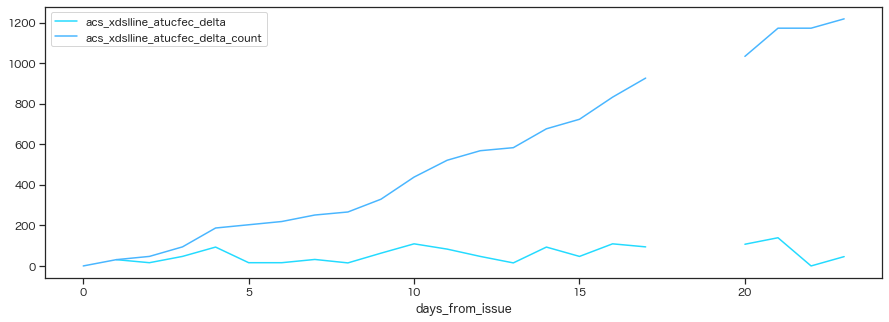

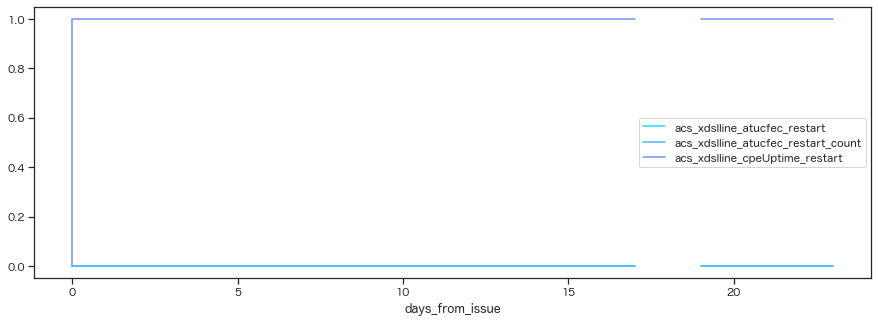

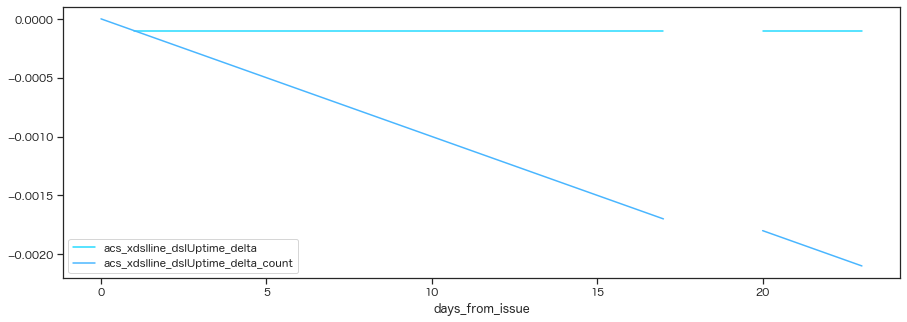

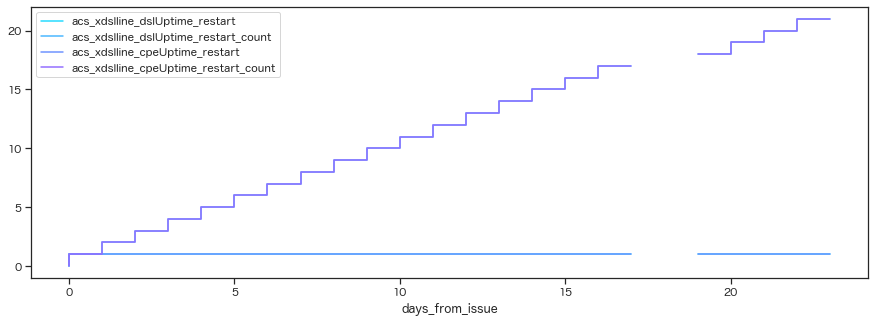

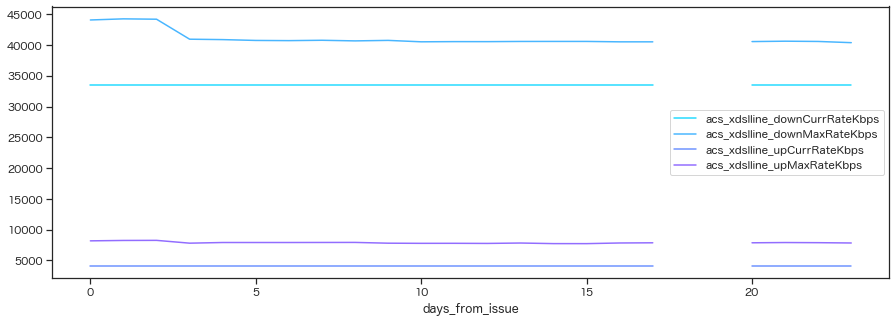

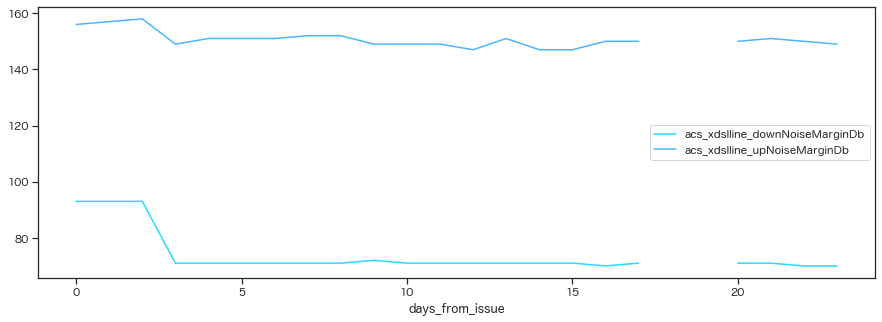

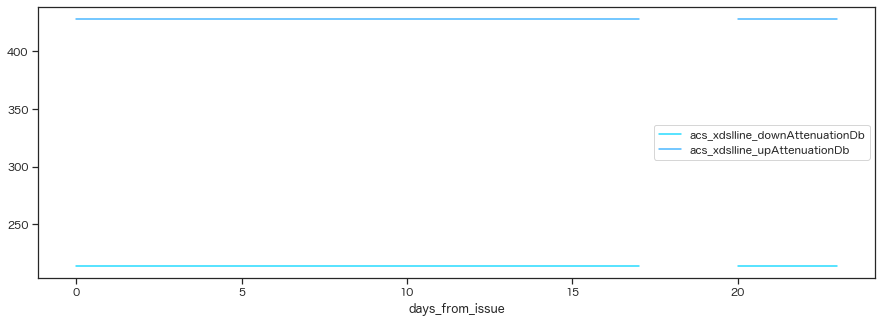

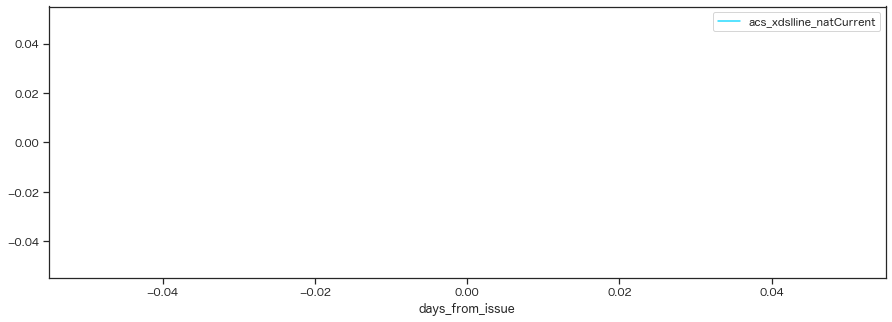

In [294]:
field = 'acs_xdslline_atucfec'
#counters
input_matrix,columns_array = train_instance(df_filter,unique_asset_id[cpe_index])
data = pd.DataFrame(input_matrix, columns=columns_array)

df_filter = df_filter.sort_values(by='acs_createdmsec')

#print('CPE ISSUE',data.CPE_ISSUE)
data[['days_from_issue', field+'_delta',field+'_delta_count']].plot(x='days_from_issue', figsize=(15,5))
data[['days_from_issue', field+'_restart', field+'_restart_count', 'acs_xdslline_cpeUptime_restart']].plot(x='days_from_issue', figsize=(15,5),drawstyle="steps")

field = 'acs_xdslline_dslUptime'
data[['days_from_issue', field+'_delta',field+'_delta_count']].plot(x='days_from_issue', figsize=(15,5))
data[['days_from_issue', field+'_restart', field+'_restart_count', 'acs_xdslline_cpeUptime_restart','acs_xdslline_cpeUptime_restart_count']].plot(x='days_from_issue', figsize=(15,5),drawstyle="steps")



# Measurements
data[['days_from_issue', 'acs_xdslline_downCurrRateKbps','acs_xdslline_downMaxRateKbps','acs_xdslline_upCurrRateKbps','acs_xdslline_upMaxRateKbps']].plot(x='days_from_issue', figsize=(15,5))
data[['days_from_issue', 'acs_xdslline_downNoiseMarginDb','acs_xdslline_upNoiseMarginDb']].plot(x='days_from_issue', figsize=(15,5))
data[['days_from_issue', 'acs_xdslline_downAttenuationDb', 'acs_xdslline_upAttenuationDb']].plot(x='days_from_issue', figsize=(15,5))
data[['days_from_issue', 'acs_xdslline_natCurrent']].plot(x='days_from_issue', figsize=(15,5))


In [173]:
data.head(10)

,days_from_issue,acs_xdslline_dslUptime_delta,acs_xdslline_dslUptime_restart,acs_xdslline_dslUptime_restart_count,acs_xdslline_dslUptime_delta_count,acs_xdslline_cpeUptime_delta,acs_xdslline_cpeUptime_restart,acs_xdslline_cpeUptime_restart_count,acs_xdslline_cpeUptime_delta_count,acs_xdslline_transmitBlocks_delta,acs_xdslline_transmitBlocks_restart,acs_xdslline_transmitBlocks_restart_count,acs_xdslline_transmitBlocks_delta_count,acs_xdslline_receiveBlocks_delta,acs_xdslline_receiveBlocks_restart,acs_xdslline_receiveBlocks_restart_count,acs_xdslline_receiveBlocks_delta_count,acs_xdslline_atuccrc_delta,acs_xdslline_atuccrc_restart,acs_xdslline_atuccrc_restart_count,acs_xdslline_atuccrc_delta_count,acs_xdslline_atucfec_delta,acs_xdslline_atucfec_restart,acs_xdslline_atucfec_restart_count,acs_xdslline_atucfec_delta_count,acs_xdslline_cpuUsagePercentage,acs_xdslline_freeMemoryKb,acs_xdslline_totalMemoryKb,acs_xdslline_usedMemoryKb,acs_xdslline_natCurrent,acs_xdslline_natMax,acs_xdslline_downAttenuationDb,acs_xdslline_downCurrRateKbps,acs_xdslline_downMaxRateKbps,acs_xdslline_downNoiseMarginDb,acs_xdslline_downPowerDbm,acs_xdslline_upAttenuationDb,acs_xdslline_upCurrRateKbps,acs_xdslline_upMaxRateKbps,acs_xdslline_upNoiseMarginDb,acs_xdslline_upPowerDbm,dslam_avg_bitrate_us,dslam_avg_bitrate_ds,dslam_avg_attenuation_ds,dslam_avg_attenuation_us,dslam_avg_power_us,dslam_avg_power_ds,dslam_avg_att_bitrate_us,dslam_avg_att_bitrate_ds,dslam_avg_snr_us,dslam_avg_snr_ds,dslam_no_counts,dslam_avg_bandline_ds,dslam_avg_bandline_us,dslam_sum_cv_us,dslam_count_cv_us,dslam_sum_cv_ds,dslam_count_cv_ds,dslam_sum_es_ds,dslam_count_es_ds,dslam_sum_es_us,dslam_count_es_us,dslam_sum_ses_ds,dslam_count_ses_ds,dslam_sum_ses_us,dslam_count_ses_us,dslam_sum_fec_ds,dslam_count_fec_ds,dslam_sum_fec_us,dslam_count_fec_us,dslam_code_of_dominant_modulation,snmp_no_lossoflink,snmp_no_linkup,snmp_no_dyinggasp,acs_crm_accessNetwork_0,acs_crm_accessNetwork_ADSL,acs_crm_accessNetwork_ETH,acs_crm_accessNetwork_UNKNOWN,acs_crm_accessNetwork_VDSL,dslam_iptv_N,dslam_iptv_Y,dslam_model_EDA MEDIUM SUBRACK,dslam_model_EDA SMALL SUBRACK,dslam_model_EDA VDSL SUBRACK,dslam_model_MA5600T,dslam_model_MA5603T,dslam_model_MA5608T,dslam_model_MA5623A,cpetype_HA35-11,cpetype_Speedport Plus,cpetype_Speedport Plus181,cpetype_W724Ci,cpetype_W724Ci_11AC
0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,737.0,8490.0,49.3,36.129412,13.0,18.800000,724.368421,9696.000000,7.741176,7.963158,17.0,NaN,NaN,1.0,38.0,38.0,39.0,29.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,5.0,3.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,737.0,8490.0,49.3,36.200000,13.0,18.811111,723.055556,9668.631579,7.700000,7.911765,16.0,NaN,NaN,0.0,35.0,34.0,35.0,22.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,7.0,3.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,737.0,8490.0,49.3,36.200000,13.0,18.780000,721.333333,9615.764706,7.663158,7.900000,21.0,NaN,NaN,2.0,27.0,3138.0,28.0,284.0,25.0,2.0,2.0,59.0,4.0,0.0,0.0,0.0,0.0,7.0,4.0,3.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,737.0,8490.0,49.3,36.200000,13.0,18.818182,722.095238,9618.947368,7.685714,7.910000,20.0,NaN,NaN,0.0,26.0,1493.0,24.0,291.0,13.0,0.0,0.0,14.0,2.0,0.0,0.0,0.0,0.0,5.0,2.0,3.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,

## 3. Train Model Base Line

In [411]:
import ipyplot
ipyplot.plot_images(['../data/external/images/diag2.png'], ['Attenuation'], img_width=1300)

Dataset class
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.
__getitem__ to support the indexing such that dataset[i] can be used to get ith sample
Let’s create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}. Our dataset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

## 4. Convolutional NeuralNet for Time series

### 4.1 Create Time series Dataset for our AutoEncoder 

In [295]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReplacementDataset(Dataset):
    """
    Creates dataset from click behaviors and news titles.
    """
    def __init__(self, data_path, product_class=None, targe_label=None, scaler=None):
        """Init paramaters for dataset building.
        
        Args:
            params (dict): Dictionary of configuration parameters.
            path_data (str): Path to data.
        """
        super(ReplacementDataset, self).__init__()
        self.data_path = data_path
        self.product_class = product_class
        self.data, self.asset_ids = self.read_data()
        self.target_label = targe_label
        self.scaler = scaler
        
        
    def binary_labeling(self, label):
        # do some stuff self.target_label
        if label == self.target_label:
            labels_binary=1
        else:
            labels_binary=0
        return labels_binary
    
    def read_data(self):
        #data = pd.read_csv(self.data_path)
        data = pd.read_csv(self.data_path,dtype={'assetid': object})
        if self.product_class is not None:
            data = data.loc[data.cpetype == self.product_class]
        asset_ids  = data.assetid.unique()
        return data, asset_ids
    
    def __len__(self):
        """Dataset length.
        Returns:
            int: Dataset length.
        """
        return len(self.asset_ids)
        
    def __getitem__(self, idx: int):
        """Get item.
        Args:
            idx (int): Index.
        Returns:
            {
                str: User ID,
                list: [batch, num_click_docs, seq_len],
                list: [batch, num_candidate_docs, seq_len],
                bool: candidate docs label (0 or 1)
            }
        """
        #Labels
        label = self.data.loc[self.data.assetid==self.asset_ids[idx]]['CPE_ISSUE'].values[0]
        label = self.binary_labeling(label)
        label = torch.tensor(label).type(torch.IntTensor)
        
        #Input
        input_matrix, _ = train_instance(self.data ,self.asset_ids[idx])
        input_matrix_tensor = torch.tensor(input_matrix).type(torch.FloatTensor)
        
        if (self.scaler!=None):
            cpetype = self.data.loc[self.data.assetid==self.asset_ids[idx]]['cpetype'].values[0]
            scale_denominator = (self.scaler[cpetype][1]-self.scaler[cpetype][0])
            scale_denominator[scale_denominator==0.0]=1.0
            input_matrix_tensor= (input_matrix_tensor-self.scaler[cpetype][0])/(scale_denominator)
            input_matrix_tensor[torch.isnan(input_matrix_tensor)] = -1.0
        return label, input_matrix_tensor

In [601]:
window, prediction_gap = 30,1
data_path = "../data/interim/df_train_2.csv" #"../data/raw/data_w"+str(window)+"_g"+str(prediction_gap)+"/issues.csv"
cpe_type = 'HA35-11'
dataset = ReplacementDataset(data_path, cpe_type, None,scaler=None)

In [602]:
dataset.__len__()

1370

In [603]:
print(65*'-'+'\n''Sample:\n'+65*'-'+'\n',dataset.__getitem__(12)[1])

-----------------------------------------------------------------
Sample:
-----------------------------------------------------------------
 tensor([[ 0.0000e+00,         nan,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -1.0000e-04,  1.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0000e+00, -1.0000e-04,  1.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 2.7000e+01,         nan,         nan,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.8000e+01,         nan,         nan,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.9000e+01,         nan,         nan,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


### 4.2 Create robust scaler for the dataset features

In [604]:
def max_min_scaler(dataset, samples):
    data_loader =DataLoader(dataset, batch_size=samples, shuffle=True)
    for i, batch in enumerate(data_loader):
        _,x = batch
        break
    max_scale =[]
    min_scale = []
    for i in range(x.shape[0]):
        max_scale.append(np.nanmax(x[i],axis=0))
        min_scale.append(np.nanmin(x[i],axis=0))
    max_scale = np.nanmax(np.array(max_scale),axis=0)
    min_scale = np.nanmin(np.array(min_scale),axis=0)
    return min_scale, max_scale

In [605]:
cpe_types = ['HA35-11','Speedport Plus181','W724Ci','W724Ci_11AC','ZXDSL 931VII V4.0','ZXDSL931VII']

In [606]:
window, prediction_gap = 30,1
data_path = "../data/interim/df_train_2.csv"
scaler_cpetype = dict()
for cpe_type in cpe_types:
    print(cpe_type)
    samples = 300
    dataset = ReplacementDataset(data_path, cpe_type, None, scaler=None)
    scaler_cpetype[cpe_type] = max_min_scaler(dataset, samples)

HA35-11
Speedport Plus181
W724Ci
W724Ci_11AC
ZXDSL 931VII V4.0
ZXDSL931VII


Let' save the scaler

In [607]:
import pickle
scaler_file = open("../data/preprocessed/anomaly_scaler.pkl", "wb")
pickle.dump(scaler_cpetype, scaler_file)
scaler_file.close()

Now we can reload the max min values per feature per cpe type

In [608]:
scaler_file = open("../data/preprocessed/anomaly_scaler.pkl", "rb")
scaler_cpetype = pickle.load(scaler_file)
scaler_cpetype[cpe_types[1]]

(array([ 0.0000000e+00, -9.9999997e-05,  0.0000000e+00,  0.0000000e+00,
        -2.3000001e-03, -9.9999997e-05,  0.0000000e+00,  0.0000000e+00,
        -2.3000001e-03,  2.1295920e+07,            nan,  0.0000000e+00,
         0.0000000e+00,            nan,  0.0000000e+00,            nan,
         0.0000000e+00,  0.0000000e+00,            nan,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.4720000e+03,
         8.1460000e+04,  6.3136000e+04,  1.0000000e+00,  8.0000000e+03,
         0.0000000e+00,  5.1200000e+02,  3.0680000e+03,            nan,
        -3.0000000e+00,  2.0000000e+00,  2.9300000e+02,  1.8800000e+02,
                   nan, -1.5000000e+01,  3.2000000e+02,  5.1200000e+02,
         2.8000000e+00,  8.0000001e-01, -1.6299999e+01, -3.6318183e+00,
         2.9919226e+02,  3.0680000e+03,  4.1304347e-01,  1.88235

Now we can pass as argument `min_features` and `max_features` to the class `ReplacementDataset` 

In [609]:
window, prediction_gap = 30,1
data_path = "../data/interim/df_train_2.csv" #"../data/raw/data_w"+str(window)+"_g"+str(prediction_gap)+"/issues.csv"
cpe_type = 'HA35-11'
dataset = ReplacementDataset(data_path, cpe_type, 'healthy',scaler=scaler_cpetype)

In [613]:
dataset.__len__()

1370

In [610]:
dataset.__getitem__(0)

(tensor(1, dtype=torch.int32),
 tensor([[ 0.0000, -1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0345,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0690,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.9310, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.9655, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000]]))

In [611]:
input_matrix = dataset.__getitem__(0)[1]
input_matrix

tensor([[ 0.0000, -1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0345,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0690,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.9310, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9655, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [612]:
input_matrix.shape

torch.Size([30, 102])

## 5. Modeling

### 5.1 Encoder

In [425]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvEncoder(nn.Module):
    """ 1D Convolution autoencoder.
    """
    def __init__(self, features_dim, latent_dim):
        """Init  1-D ConvolutionalEncoder.
        Args:
            hparams (dict): Configuration parameters.
            weight (tensor): Embeding weight.
        """
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=features_dim, out_channels=2*features_dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=2*features_dim, out_channels=4*features_dim, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, stride=2)
        self.flatten = nn.Flatten(start_dim=1)
        self.batch_norm1 = nn.BatchNorm1d(2*features_dim)
        self.batch_norm2 = nn.BatchNorm1d(4*features_dim)
        linear_dim_input = 2856
        self.linear = nn.Linear(linear_dim_input, latent_dim, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x
        

### 5.2 Decoder

In [426]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvDecoder(nn.Module):
    """ 1D Convolution autoencoder.
    """
    def __init__(self, features_dim, latent_dim):
        """Init  1-D ConvolutionalEncoder.
        Args:
            hparams (dict): Configuration parameters.
            weight (tensor): Embeding weight.
        """
        super(ConvDecoder, self).__init__()
        self.features_dim = features_dim
        self.latent_dim = latent_dim
        self.t_conv1 = nn.ConvTranspose1d(4*features_dim, 2*features_dim, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose1d(2*features_dim, features_dim, 2, stride=2)
        self.batch_norm1 = nn.BatchNorm1d(2*features_dim)
        linear_dim_input = 2856
        self.linear = nn.Linear(latent_dim, linear_dim_input, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.shape[0], 4*self.features_dim, -1)
        x = self.t_conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.t_conv2(x)
        x = F.tanh(x)
        return x
        

### 5.3 AutoEncoder

In [427]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn

class ConvNetAutoEncoder(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super(ConvNetAutoEncoder,self).__init__()
        
        
        # Hyperparameters
        self.learning_rate = learning_rate
        # Log hyperparameters
        self.save_hyperparameters()
        
        # model
        self.latent_dim = 256
        self.features_dim = 102 
        self.layer_norm= nn.LayerNorm([window])
        self.encoder = ConvEncoder(self.features_dim, self.latent_dim)
        self.decoder = ConvDecoder(self.features_dim, self.latent_dim)

        
    def forward(self, x):
        # Normalization of the time series per feature and permutation of between Features and Lenth of the Time series
        #x = self.layer_norm(x.permute(0,2,1))
        embeddings = self.encoder(x)
        return embeddings
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        _,x = batch
        # Normalization of the time series per feature and permutation of between Features and Length of the Time series
        x = x.permute(0,2,1)
        #x = self.layer_norm(x)
        embeddings = self.encoder(x)
        x_hat = self.decoder(embeddings) 
        loss = torch.mean((torch.mean(((x-x_hat)**2),2)))#F.mse_loss(x,x_hat)
        #loss = nn.MSELoss(x,x_hat)
        

        #print(30*'-')
        #print('BATCH ID',batch_idx)
        #print('Loss',loss)
        #print(30*'-')
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

#     def training_epoch_end(self, loss):
#         avg_val_loss = torch.tensor([x for x in loss]).mean()
#         self.log('training_loss', avg_train_loss)
    
    def validation_step(self, batch, batch_idx):
        _,x = batch
        # Normalization of the time series per feature and permutation of between Features and Lenth of the Time series
        x = x.permute(0,2,1)
        #x = self.layer_norm(x)
        embeddings = self.encoder(x)
        x_hat = self.decoder(embeddings) 
        outputs = torch.mean((torch.mean(((x-x_hat)**2),2)))## F.mse_loss(x,x_hat)#nn.MSELoss(x,x_hat)
        return outputs
        
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.tensor([x for x in outputs]).mean()
        self.log('val_loss', avg_val_loss)

    def test_step(self, batch, batch_idx):
        _,x = batch
        x = x.permute(0,2,1)
        #x = self.layer_norm(x)
        embeddings = self.encoder(x)
        x_hat = self.decoder(embeddings) 
        loss = torch.mean((torch.mean(((x-x_hat)**2),2)))#nn.MSELoss(x,x_hat)#
        self.log('test_loss', loss)


### 5.5 Export data to disk

>1. This step is mainly for the optimization sincif we load call the `Replacement Dataset` in our Dataloader it will take so much time to load the data because at every call preprocsiing has been called that's why during Training a model takes so much time.
>2. So to skip the preprocessing at every call we can save each instances in our disk and directly load it in a `Dataloader`, this makes the training lot faster and reduces the training time by *50* times.

In [331]:
def prepare_data(data_path, store_path, product_class, target_label, scaler):
    '''
    This function will export each instance to a specific location
     
    Args:
        data_path (str): Path to load data and create dataset.
        store_path (str): Path to save data.
        product_class (str): CPE types
        target_label (str): Target label
        scaler: scaler matrix
    
    '''
    dataset = ReplacementDataset(data_path,product_class,target_label,scaler)
        #Save Each training instace at a particular location
    for i in range(dataset.__len__()):
        torch.save(dataset.__getitem__(i), store_path+'tensor_{}.pt'.format(i))

In [336]:
import os

Export training instance per cpe type

In [618]:
window, prediction_gap = 30,1
product_class = 'Speedport Plus181'
target_label = 'healthy'
data_path = "../data/interim/df_train_2.csv"
store_path = "../data/preprocessed/train_instances_cpetype/"
scaler = scaler_cpetype

In [619]:
store_path = "../data/preprocessed/train_instances_cpetype/" 
cpe_type = "Speedport Plus181/"
if not os.path.exists(store_path+cpe_type):
    os.makedirs(store_path+cpe_type)
prepare_data(data_path, store_path+cpe_type, product_class, target_label, scaler)

In [620]:
dataset = ReplacementDataset('../data/interim/df_train_2.csv','Speedport Plus181','healthy',scaler=scaler_cpetype)

In [621]:
dataset.__len__()

1239

Let's export the testing instances

In [440]:
window, prediction_gap = 30,1
product_class = 'W724Ci'
target_label = 'healthy'
data_path = "../data/interim/df_test_2.csv"
store_path = "../data/preprocessed/test_instances_new/"
scaler = scaler_cpetype

In [441]:
store_path = "../data/preprocessed/test_instances_new/" 
cpe_type = "W724Ci/"
if not os.path.exists(store_path+cpe_type):
    os.makedirs(store_path+cpe_type)
prepare_data(data_path, store_path+cpe_type, product_class, target_label, scaler)

In [367]:
prepare_data(data_path, store_path, product_class, target_label, scaler)

### 5.6 Load the each instances and create a dataset

>Now after saving the preprocessed data to disk we can directly load the instanes in `Dataset` class and can load that `Dataset` into the model.

In [442]:
class LoadDataset(torch.utils.data.Dataset):
    """
    Load the instances from the disk
    
    """
    
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = os.listdir(root)# take all files in the root directory
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        sample = torch.load(os.path.join(self.root, self.files[idx])) # load the features of this sample
        if self.transform:
            sample = self.transform(sample)
        return sample

### 5.7 `LightningDataModule`

DataLoaders and data processing code tends to end up scattered around. Make your data code reusable by organizing it into a LightningDataModule.

In [992]:
from pytorch_lightning import LightningDataModule 

class ReplacementDataModule(LightningDataModule):

    def __init__(self, batch_size=32, num_workers=8):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers= num_workers
    
    def setup(self, stage=None):
        
        window, prediction_gap = 30,1
        product_class = 'Speedport Plus181/'
        
        #Load Train data
        path_train = '../data/preprocessed/train_instances_cpetype/'
        train_data = LoadDataset(path_train+product_class)
        
        #Load test data
        path_test = '../data/preprocessed/test_instances_cpetype/'
        test_data = LoadDataset(path_test+product_class)
        
        if stage == 'fit' or stage is None:
            self.train_dataset = train_data
            self.val_dataset = test_data
            
        if stage == 'test' or stage is None:
            self.test_dataset = self.val_dataset        
    

    def train_dataloader(self):
        # Called when training the model
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        # Called when evaluating the model (for each "n" steps or "n" epochs)
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def test_dataloader(self):
        # Called when testing the model by calling: Trainer.test()
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)


In [993]:
# init model
import timeit
start = timeit.default_timer()

model = ConvNetAutoEncoder(learning_rate=0.001)

# init data
data_module = ReplacementDataModule(batch_size=32, num_workers=0)# JupyterNotebook is SPAWN Workers>0 are not supported

# Define Logger
#logger = TensorBoardLogger(save_dir='lightning_logs/cpe_replacement_autoencoder', name='Speedport Plus181')W724Ci
#logger = TensorBoardLogger(save_dir='new_lightning_logs/ad_cpe_replacement_autoencoder', name='HA35-11')
#logger = TensorBoardLogger(save_dir='new_lightning_logs/ad_cpe_replacement_autoencoder', name='W724Ci')
logger = TensorBoardLogger(save_dir='new_lightning_logs/ad_cpe_replacement_autoencoder', name='Speedport Plus181')

# Define Trainer
trainer = pl.Trainer(max_epochs=100, 
                     check_val_every_n_epoch=1, 
                     precision=32,
                     logger=logger,
                     log_every_n_steps=1)

#train
trainer.fit(model, data_module)

stop = timeit.default_timer()
print('Time: ', stop - start)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name       | Type        | Params
-------------------------------------------
0 | layer_norm | LayerNorm   | 60    
1 | encoder    | ConvEncoder | 1.0 M 
2 | decoder    | ConvDecoder | 1.0 M 
-------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.286     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Time:  325.2233001959976


## 6. `TensorBoard` Experiment Logs

In [994]:
trainer

In [995]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [996]:
#%tensorboard --logdir lightning_logs/cpe_replacement_autoencoder --host localhost
%tensorboard --logdir new_lightning_logs/ad_cpe_replacement_autoencoder --host localhost

Reusing TensorBoard on port 6007 (pid 48319), started 23:51:46 ago. (Use '!kill 48319' to kill it.)

## 7. Check Autoencoder

In [627]:
! ls new_lightning_logs/ad_cpe_replacement_autoencoder/HA35-11/version_0/checkpoints

epoch=89-step=3869.ckpt


In [798]:
# ----------------------------------
# to use as embedding extractor
# ----------------------------------
autoencoder_HA35 = ConvNetAutoEncoder.load_from_checkpoint('new_lightning_logs/ad_cpe_replacement_autoencoder/HA35-11/version_0/checkpoints/epoch=89-step=3869.ckpt')
encoder_model_HA35 = autoencoder_HA35.encoder
encoder_model_HA35.eval()

# ----------------------------------
# to use as image generator
# ----------------------------------
decoder_model_HA35 = autoencoder_HA35.decoder
decoder_model_HA35.eval()

ConvDecoder(
  (t_conv1): ConvTranspose1d(408, 204, kernel_size=(3,), stride=(2,))
  (t_conv2): ConvTranspose1d(204, 102, kernel_size=(2,), stride=(2,))
  (batch_norm1): BatchNorm1d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=256, out_features=2856, bias=True)
)

### 7.1 CPE Type HA3511- Check reconstruction error and losses for Training data

In [800]:
product_class = 'HA35-11'
data_path = "../data/interim/df_train_2.csv"
dataset_HA35= ReplacementDataset(data_path, product_class, 'healthy' , scaler=scaler_cpetype)

In [802]:
print('Total AssetIds in HA35-11:  ',dataset_HA35.__len__())

Total AssetIds in HA35-11:   1370


In [803]:
x = dataset_HA35.__getitem__(30)[1]
x = x.unsqueeze(0)
x_hat = decoder_model_HA35(encoder_model_HA35(x.permute(0,2,1))).permute(0,2,1)[0]

In [804]:
df_hat = pd.DataFrame(x_hat.detach().cpu().numpy())
df_hat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
0,0.007897,-0.987047,0.089918,-0.019364,0.984282,-0.984122,0.058955,-0.018426,0.982497,-0.986433,-0.989024,0.013515,-0.001854,-0.986254,0.034765,-0.993010,0.003588,0.005090,-0.991754,0.010181,-0.988644,-0.008724,-0.008330,-0.986048,0.002010,-0.989783,-0.006508,-0.001542,-0.991078,0.008820,0.123671,0.284836,0.000137,0.734940,-0.997624,-0.997366,0.511044,0.119183,0.173228,0.410858,0.884702,0.263262,0.075322,0.033496,0.380353,0.937077,0.083802,0.002169,0.655972,0.486142,0.904783,0.883886,0.036792,0.145024,0.335881,0.442973,0.777075,-0.985485,-0.991254,-0.006479,0.026181,0.019447,0.293921,0.030455,0.305322,-0.005550,0.021248,0.022147,0.024278,-0.001235,0.005915,0.009825,0.027517,0.026288,0.017592,0.367432,-0.995483,-0.995625,-0.995883,0.992038,-0.000401,-0.001143,0.991731,0.020419,-0.001491,-0.011959,-0.003151,0.011235,0.932478,-0.019004,-0.001771,0.000805,-0.018754,-0.025479,0.974545,-0.007163,-0.000435,-0.004215,0.000973,-0.001710,0.001330,0.002289
1,0.037478,-0.002255,0.974862,0.011209,0.959273,-0.001821,0.973731,0.003688,0.960899,0.050333,0.007599,-0.030870,-0.003018,0.018199,0.030077,0.025669,-0.058247,-0.008135,0.121880,0.001987,-0.006165,-0.035320,-0.004130,-0.012266,-0.007385,0.001627,-0.054777,-0.013180,-0.012244,-0.003531,0.061172,0.286194,-0.001905,0.717705,-0.997962,-0.996053,0.518525,0.114086,0.144319,0.401195,0.874754,0.247833,0.085830,0.022467,0.371817,0.933621,0.090145,0.005250,0.647105,0.490948,0.897392,0.898271,0.022630,0.123019,0.331659,0.430203,0.850881,-0.984916,-0.987848,0.004274,0.040425,0.028611,0.346805,0.035459,0.342719,-0.000748,0.014481,0.010236,0.010908,-0.014015,-0.011048,0.009407,0.059722,0.024123,0.001835,0.347608,-0.997463,-0.996215,-0.998012,0.992157,-0.002921,-0.013726,0.992045,0.010142,-0.005310,0.019504,-0.001720,-0.013598,0.931244,-0.022131,0.001067,-0.000093,0.007824,-0.028512,0.974340,-0.015657,0.000214,-0.001241,0.001433,0.002928,-0.000265,-0.001025
2,0.079668,-0.001909,0.988877,0.064444,0.910407,-0.002859,0.988626,0.066290,0.911200,0.100981,0.037399,0.048153,-0.023887,0.026491,0.043887,0.039897,0.022001,-0.026308,0.104116,0.008778,0.000749,0.007323,-0.033492,0.005680,0.003650,0.008343,0.014023,-0.008216,0.015445,0.012998,0.100520,0.314450,0.004854,0.718731,-0.998351,-0.998672,0.540515,0.086592,0.158296,0.464714,0.898052,0.217751,0.092050,0.019867,0.408983,0.936382,0.088988,0.001158,0.674848,0.521231,0.905047,0.876710,0.032274,0.145346,0.377376,0.496197,0.867234,-0.994149,-0.996162,-0.002261,0.026094,-0.008434,0.257782,0.008637,0.255172,-0.006900,0.016239,-0.011647,-0.004992,-0.010891,-0.004130,-0.033538,0.018777,0.031824,0.026947,0.351610,-0.994922,-0.994103,-0.995159,0.996200,-0.003213,0.000653,0.994516,0.011247,-0.001620,-0.004920,-0.005607,-0.043270,0.943258,-0.001874,-0.002366,-0.002379,0.012807,-0.011306,0.983543,-0.000289,0.002339,-0.000681,-0.000192,0.000871,0.001582,0.000612
3,0.113408,0.003006,0.990072,0.105718,0.872084,0.004966,0.989249,0.115077,0.872079,0.075560,0.028347,-0.005995,-0.011205,0.023212,0.038786,0.031454,0.001020,-0.030716,0.120659,0.007035,0.004566,-0.010769,-0.032956,0.000374,0.002421,0.004037,0.011559,-0.011591,0.002679,0.003408,0.079770,0.294544,0.004886,0.720587,-0.998993,-0.998663,0.542308,0.080616,0.155119,0.472025,0.895626,0.220923,0.087124,0.022866,0.407880,0.938546,0.100951,0.002588,0.682595,0.518969,0.903470,0.897030,0.024931,0.137138,0.366884,0.491010,0.871682,-0.993046,-0.994739,-0.006171,0.007784,-0.005656,0.221798,-0.003156,0.245025,-0.005387,0.019660,-0.009410,-0.008768,-0.012544,-0.006861,-0.045812,0.006434,0.026473,0.011313,0.353358,-0.996050,-0.996672,-0.997803,0.996433,-0.001714,-0.012079,0.994064,-0.001467,-0.017412,0.014420,-0.000679,-0.044390,0.94134

In [805]:
df_norm = pd.DataFrame(x[0].detach().cpu().numpy())
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
0,0.000000,-1.0,0.0,0.000000,1.000000,-1.0,0.0,0.000000,1.000000,-1.000000,-1.000000,0.0,0.0,-1.000000,0.000000,-1.000000,0.0,0.0,-1.000000,0.000000,-1.000000e+00,0.0,0.0,-1.000000,0.000000e+00,-1.000000e+00,0.0,0.0,-1.000000e+00,0.000000e+00,0.109589,0.343472,0.0,0.656528,-1.0,-1.0,0.521792,0.033115,0.054069,0.468227,0.956522,0.22551,0.094553,0.051952,0.354515,0.927885,0.093653,0.002033,0.551491,0.459048,0.796279,0.944785,0.054414,0.045522,0.320075,0.496945,0.666667,-1.0,-1.0,0.0,0.0,0.000501,0.302083,0.006095,0.312500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000054,0.0125,0.333333,-1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.034483,0.0,1.0,0.043478,0.956522,0.0,1.0,0.043478,0.956522,0.078048,0.002095,0.0,0.0,0.001048,0.000306,0.032574,0.0,0.0,0.139381,0.006127,6.007774e-07,0.0,0.0,0.000001,8.869094e-08,2.879496e-07,0.0,0.0,5.039402e-07,3.288019e-08,0.095890,0.354599,0.0,0.645401,-1.0,-1.0,0.521792,0.033115,0.053196,0.484950,0.956522,0.22551,0.094553,0.051952,0.354515,0.927885,0.093653,0.002033,0.551491,0.458448,0.789289,0.944785,0.054584,0.042030,0.318971,0.468969,0.833333,-1.0,-1.0,0.0,0.0,0.000198,0.375000,0.002353,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.333333,-1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.068966,0.0,1.0,0.086957,0.913043,0.0,1.0,0.086957,0.913043,0.104039,0.002619,0.0,0.0,0.001048,0.000688,0.040719,0.0,0.0,0.139380,0.013785,0.000000e+00,0.0,0.0,0.000000,8.869094e-08,1.919664e-07,0.0,0.0,2.687597e-07,5.480031e-08,0.054795,0.411350,0.0,0.588650,-1.0,-1.0,0.521792,0.033115,0.040838,0.387960,0.956522,0.22551,0.094553,0.052236,0.357860,0.927885,0.093653,0.002033,0.551491,0.458048,0.784846,0.944785,0.054855,0.041574,0.320372,0.464248,0.916667,-1.0,-1.0,0.0,0.0,0.000247,0.187500,0.002706,0.177083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000054,0.0125,0.333333,-1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.103448,0.0,1.0,0.130435,0.869565,0.0,1.0,0.130435,0.869565,0.026073,0.001047,0.0,0.0,0.001048,0.000841,0.016287,0.0,0.0,0.139388,0.016849,6.007774e-07,0.0,0.0,0.000002,1.773819e-07,1.279776e-07,0.0,0.0,4.479644e-07,6.941373e-08,0.054795,0.373145,0.0,0.626855,-1.0,-1.0,0.521792,0.033115,0.050375,0.454850,0.956522,0.22551,0.094553,0.052236,0.357860,0.927885,0.093653,0.002033,0.551491,0.453762,0.784846,0.944785,0.054753,0.041552,0.317697,0.462274,0.875000,-1.0,-1.0,0.0,0.0,0.000355,0.197917,0.005389,0.208333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.333333,-1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.137931,0.0,1.0,0.173913,0.826087,0.0,1.0,0.173913,0.826087,0.104215,0.002619,0.0,0.0,0.001046,0.001224,0.040720,0.0,0.0,0.139195,0.024507,6.007774e-06,0.0,0.0,0.000008,1.064291e-06,5.758992e-06,0.0,0.0,8.051901e-06,7.270175e-07,0.054795,0.400964,0.0,0.599036,-1.0,-1.0,0.521792,0.033115,0.050644,0.451505,0.956522,0.22551,0.094553,0.052378,0.361204,0.927885,0.093653,0.002033,0.551491,0.454048,0.784846,0.944785,0.054786,0.040230,0.318345,0.442131,0.875000,-1.0,-1.0,0.0,0.0,0.001285,0.208333,0.012495,0.218750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000781,0.0250,0.333333,-1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [888]:
def plot_original_reconstruction(dataset,encoder_model,decoder_model,row_num,idx_col):
    '''
    This function plot the original matrix bs reconstructed matrix
    
    Args:
        dataset: dataset of CPE
        encoder_model: encoder model of cpe type
        decoder_model: decoder model of cpe type
        row_num(int): row number of a datset to access
        idx_col(int): index number of column
        
    Returns:
        Plot the Distribution of Original vs Reconstructed of the index column
    '''
    x = dataset.__getitem__(row_num)[1]
    x = x.unsqueeze(0)
    x_hat = decoder_model(encoder_model(x.permute(0,2,1))).permute(0,2,1)[0]
    
    df_normal = pd.DataFrame(x[0].detach().cpu().numpy())
    df_hat = pd.DataFrame(x_hat.detach().cpu().numpy())
    
    df_normal[idx_col].plot(figsize=(15,6),label='Normal')
    df_hat[idx_col].plot(figsize=(15,6),label='Reconstructed')
    plt.title('Original vs Reconstruction')
    plt.xlabel('days_from_issue')
    plt.ylabel('Values of a seclected column')
    plt.legend()

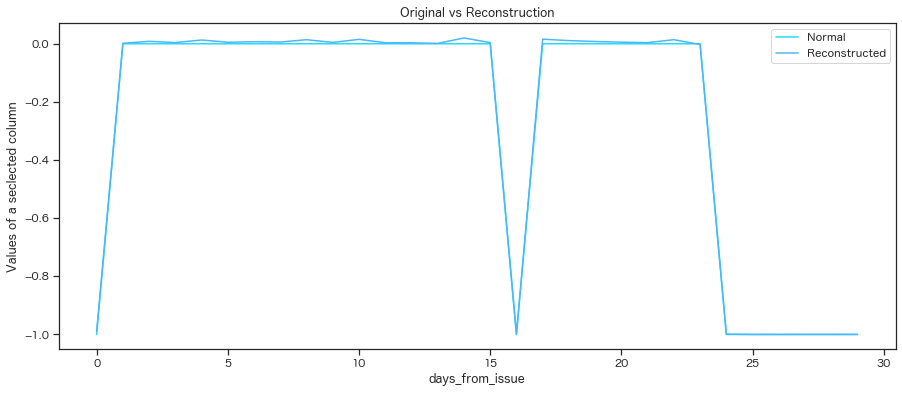

In [889]:
plot_original_reconstruction(dataset_HA35,encoder_model_HA35,decoder_model_HA35,row_num=30,idx_col=25)

In [812]:
def summation_loss(dataset,encoder_model,decoder_model):
    '''
    This function will sum the lossses of each row 
    
    Args:
        dataset(): dataset
    Returns:
        losses: list of all the losses per row in a dataset
    '''
    
    losses = []
    for i in range(dataset.__len__()):
        x = dataset.__getitem__(i)[1]
        x = x.unsqueeze(0)
        x_hat = decoder_model(encoder_model(x.permute(0,2,1))).permute(0,2,1)[0]
        loss = torch.mean((torch.mean(((x-x_hat)**2),2)))
        losses.append(loss.item())
    return losses

In [813]:
losses_HA35 = summation_loss(dataset_HA35,encoder_model_HA35,decoder_model_HA35)

In [832]:
print(len(losses_HA35))
print(min(losses_HA35))
print(max(losses_HA35))

1370
0.00045029824832454324
0.03679452836513519


In [898]:
def plot_loss_distribution(loss_cpetype,bins,xl,xh):
    '''
    This function plot the distribution of the loss 
    
    Args:
        dataset(): dataset
    Returns:
        losses: list of all the losses per row in a dataset
    '''
    fig = plt.figure(figsize=(15,6))
    sns.distplot(loss_cpetype, bins=bins, kde=True,hist=False,label='Loss')
    plt.title('Distribution of loss')
    plt.xlabel('Loss')
    plt.legend(fontsize=12)
    plt.xlim(xl,xh)
    

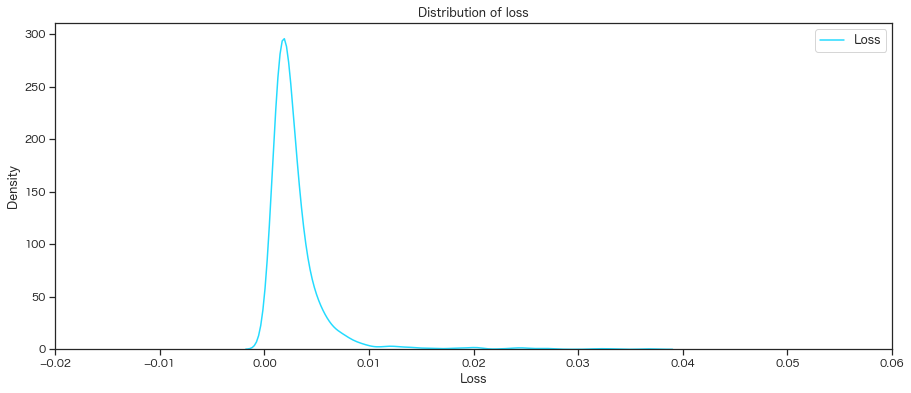

In [899]:
#Train distribution loss
plot_loss_distribution(losses_HA35,bins=100,xl=-0.02,xh=0.06)

>From the above plot we can clearly see for CPE type-: HA35-11, losses are getting converged at *0.04*. Since it's the distribution of losses of only **Healthy CPEs** so we can set **Threshold = 0.04** for detecting anomalies. Let's check it out how it's for Testing data 

### 7.2 CPE Type HA3511- Check reconstruction error and losses for Testing data

In [838]:
product_class = 'HA35-11'
data_path = "../data/interim/df_test_2.csv"
dataset_test_HA35= ReplacementDataset(data_path, product_class, 'healthy' , scaler=scaler_cpetype)

In [840]:
print('Total Assetds: ',dataset_test_HA35.__len__())

Total Assetds:  242


In [841]:
#df_test.loc[(df_test.cpetype=='HA35-11') & (df_test.CPE_ISSUE=='power_supply')]['assetid'].unique()

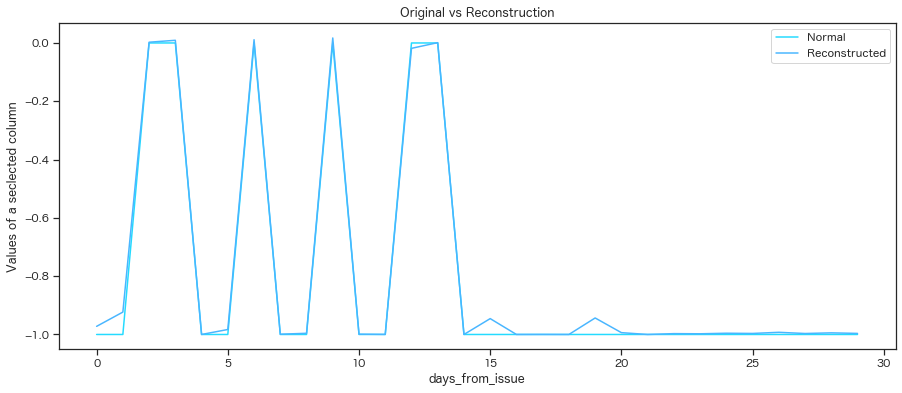

In [900]:
# Training loss 
plot_original_reconstruction(dataset_test_HA35,encoder_model_HA35,decoder_model_HA35,row_num=60,idx_col=25)

In [847]:
losses_test_HA35= summation_loss(dataset_test_HA35,encoder_model_HA35,decoder_model_HA35)
print(len(losses_test_HA35))
print(min(losses_test_HA35))
print(max(losses_test_HA35))

242
0.0006559862522408366
0.35503748059272766


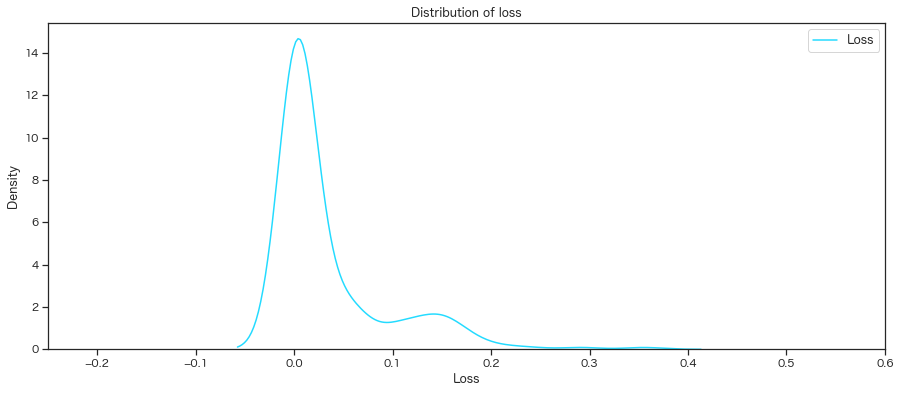

In [901]:
#Test distribution loss 
plot_loss_distribution(losses_test_HA35,bins=100,xl=-.25,xh=0.6)

> Testing set have big range of losses which is a combination of Healthy and Unhealthy CPEs we can see many losses are in more than range greater than *0.04*. So definitely there will be Anomalies so let's find ot by plotting it together.

In [852]:
def separate_losses(dataset,encoder_model,decoder_model):
    '''
    This function returns two lists of losses
    
    Args:
        dataset: dataset
    Returns:
        losses: list of losses of Healthy CPEs
        an_losses: list of losses of CPEs with anomalies
    
    '''
    losses = []
    an_losses = []
    for i in range(dataset.__len__()):
        if dataset.__getitem__(i)[0].item()==1:
            x = dataset.__getitem__(i)[1]
            x = x.unsqueeze(0)
            x_hat = decoder_model(encoder_model(x.permute(0,2,1))).permute(0,2,1)[0]
            loss1 = torch.mean((torch.mean(((x-x_hat)**2),2)))
            losses.append(loss1.item())
        elif dataset.__getitem__(i)[0].item()==0:
            x = dataset.__getitem__(i)[1]
            x = x.unsqueeze(0)
            x_hat = decoder_model(encoder_model(x.permute(0,2,1))).permute(0,2,1)[0]
            loss2 = torch.mean((torch.mean(((x-x_hat)**2),2)))
            an_losses.append(loss2.item())
    return losses,an_losses

In [853]:
normal_loss,anomaly_loss=separate_losses(dataset_test_HA35,encoder_model_HA35,decoder_model_HA35)

In [854]:
print('Total Healthy CPEs: ',len(normal_loss))
print('Total UnHealthy CPEs: ',len(anomaly_loss))

Total Healthy CPEs:  174
Total UnHealthy CPEs:  68


Text(0.5, 0, 'Healthy CPE loss')

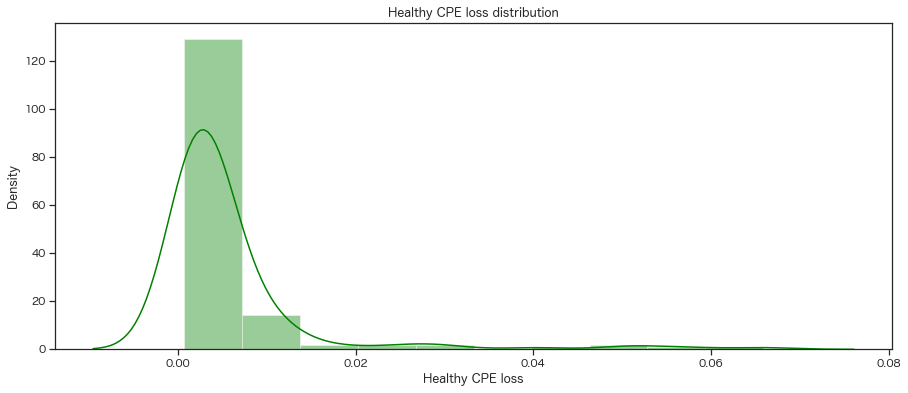

In [902]:
fig = plt.figure(figsize=(15,6))
sns.distplot(normal_loss, bins=10, kde=True,color='green')
plt.title('Healthy CPE loss distribution')
plt.xlabel('Healthy CPE loss')

Text(0.5, 0, 'Anomalies CPE loss')

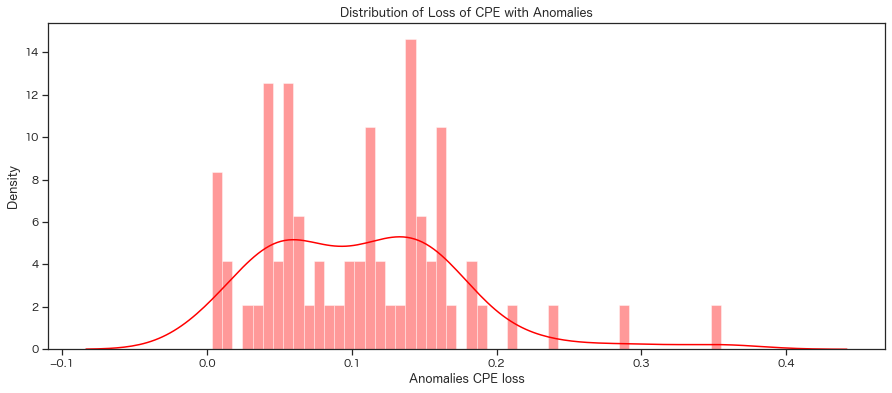

In [903]:
fig = plt.figure(figsize=(15,6))
sns.distplot(anomaly_loss, bins=50, kde=True,color='red')
plt.title('Distribution of Loss of CPE with Anomalies')
plt.xlabel('Anomalies CPE loss')

(-0.02, 0.25)

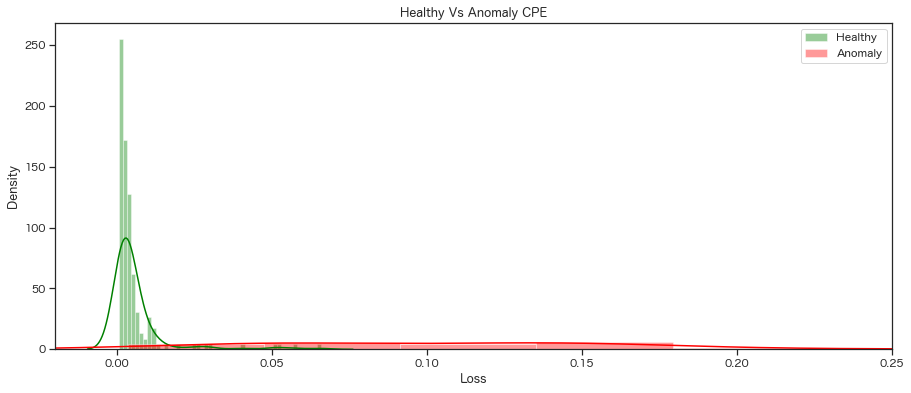

In [913]:
fig = plt.figure(figsize=(15,6))
sns.distplot(normal_loss, kde=True,color='green',label='Healthy')
sns.distplot(anomaly_loss,kde=True,color='red',label='Anomaly')
plt.title('Healthy Vs Anomaly CPE')
plt.xlabel('Loss')
plt.legend()
plt.xlim(-.02,0.25)

>**Insights**
>By looking the above graphs we can clear see for Healthy CPEs, distribution of loss is in range [-0.005, 0.04] where as for unhealthy CPEs or the CPEs have reported some issue is in  range [-1.7,20]. So we can keep our THRESHOLD=0.04 for separating the CPEs

## 8. Classifier Stage

In [862]:
def predict(dataset,encoder_model,decoder_model):
    '''
    This function returns list of losses and it's label
    
    Args:
        dataset: Replacement Dataset of CPE type
        encoder_model(model): encoder model of specific CPE type 
        decoder_model(model): decoder model of specific CPE type 
    
    Returns:
        labels(list): list of loss of each row of CPE
        losses(list): list of true label of each row of CPE
    '''
    labels = []
    losses = []
    for i in range(dataset.__len__()):
        x = dataset.__getitem__(i)[1]
        x = x.unsqueeze(0)
        x_hat = decoder_model(encoder_model(x.permute(0,2,1))).permute(0,2,1)[0]
        loss1 = torch.mean((torch.mean(((x-x_hat)**2),2)))
        losses.append(loss1.item())
        label = dataset.__getitem__(i)[0]
        labels.append(label.item())     
    return labels,losses

In [863]:
def resultant_df(dataset,encoder_model,decoder_model):
    '''
    This function returns the dataframe of the losses with labels of each asset ids
    '''
    label,loss= predict(dataset,encoder_model,decoder_model)
    error_df = pd.DataFrame({'Reconstruction_error':loss,'Healthy_CPE':label})
    return error_df

In [914]:
def visualize_anomalies(df,threshold,yl,yh):
    '''
    This function plots the anomalies
    '''
    groups = df.groupby('Healthy_CPE')
    fig, ax = plt.subplots(figsize=(13,8))
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Anomaly" if name == 0 else "Healthy")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for Healthy and Unhealthy data")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.ylim(yl,yh)
    plt.show()
    

In [915]:
def evaluation_metrics(df,threshold):
    '''
    This function returns all evaluation merics
    '''
    pred_y = [0 if e > threshold else 1 for e in df.Reconstruction_error.values]
    df['pred'] =pred_y
    conf_matrix = confusion_matrix(df.Healthy_CPE, pred_y)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    # print Accuracy, precision, recall and F1 Score
    print(" Accuracy: ",accuracy_score(df['Healthy_CPE'], df['pred']))
    print(" Recall: ",recall_score(df['Healthy_CPE'], df['pred']))
    print(" Precision: ",precision_score(df['Healthy_CPE'], df['pred']))
    print(" F1 score: ",f1_score(df['Healthy_CPE'], df['pred']))
    

In [921]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score,f1_score
LABELS = ["Abnormal","Normal"]

### 8.1 CPE Type HA35-11 Train dataset Results

In [917]:
error_df_train_HA35 = resultant_df(dataset_HA35,encoder_model_HA35,decoder_model_HA35)
print(error_df_train_HA35.shape)
error_df_train_HA35.head()

(1370, 2)


,Reconstruction_error,Healthy_CPE
0,0.003032,1
1,0.005092,1
2,0.001484,1
3,0.002829,1
4,0.001715,1


In [918]:
error_df_train_HA35.describe()

,Reconstruction_error,Healthy_CPE
count,1370.000000,1370.0
mean,0.002990,1.0
std,0.003148,0.0
min,0.000450,1.0
25%,0.001511,1.0
50%,0.002166,1.0
75%,0.003266,1.0
max,0.036795,1.0


In [919]:
error_df_train_HA35.Healthy_CPE.value_counts()

1    1370
Name: Healthy_CPE, dtype: int64

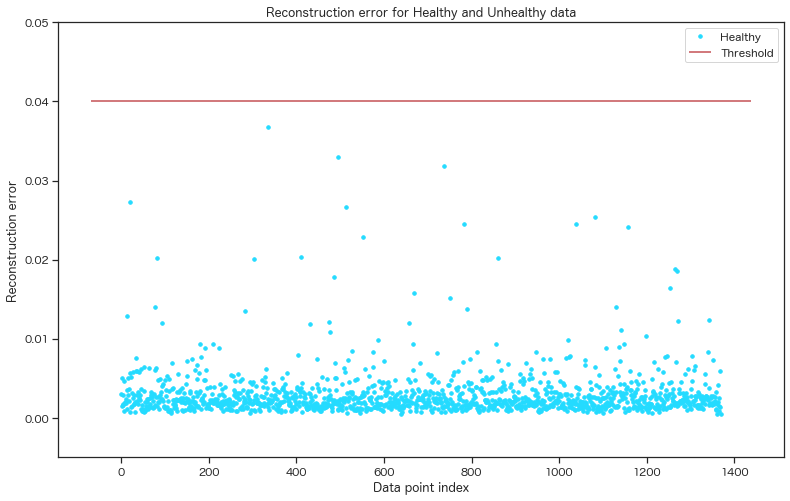

In [936]:
visualize_anomalies(error_df_train_HA35,threshold=0.04,yl=-0.005,yh=0.05)

> Wow our Threshold=0.04 is working fine all Healthy CPEs have *Reconstruction error* less than 0.04. Let's check the evaluation metrics.

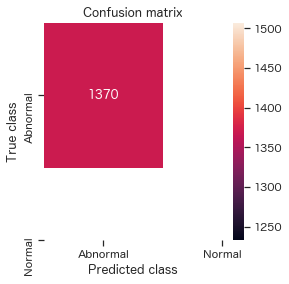

 Accuracy:  1.0
 Recall:  1.0
 Precision:  1.0
 F1 score:  1.0


In [922]:
evaluation_metrics(error_df_train_HA35,threshold=0.04)

> Perfect we have 100% identified the Healthy CPE. But it could be the case of Overfitting also so let's check out the performace of Testing set

### 8.1 CPE Type HA35-11 - TEST Dataset Results

In [864]:
error_df_test_HA35 = resultant_df(dataset_test_HA35,encoder_model_HA35,decoder_model_HA35)
print(error_df_test_HA35.shape)
error_df_test_HA35.head()

(242, 2)


,Reconstruction_error,Healthy_CPE
0,0.004539,1
1,0.006218,1
2,0.001499,1
3,0.004280,1
4,0.001959,1


In [866]:
error_df_test_HA35.Healthy_CPE.value_counts()

1    174
0     68
Name: Healthy_CPE, dtype: int64

In [927]:
error_df_test_HA35.describe()

,Reconstruction_error,Healthy_CPE,pred
count,242.000000,242.000000,242.000000
mean,0.033947,0.719008,0.731405
std,0.058152,0.450415,0.444147
min,0.000656,0.000000,0.000000
25%,0.001989,0.000000,0.000000
50%,0.004405,1.000000,1.000000
75%,0.044681,1.000000,1.000000
max,0.355037,1.000000,1.000000


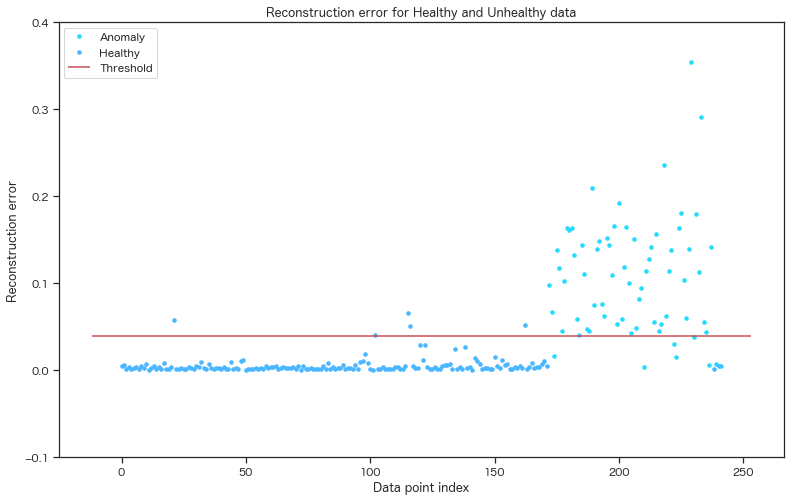

In [934]:
visualize_anomalies(error_df_test_HA35,threshold=0.04,yl=-0.1,yh=0.4)

>So **Threshold=0.04** is really working also on the Testing set also. We can clearly differentiate among Healthy and Unhealthy CPEs by the set Threshold.

In [703]:
# threshold_fixed = 0.04
# groups = error_df.groupby('Healthy_CPE')
# fig, ax = plt.subplots(figsize=(8,5))
# for name, group in groups:
#     ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
#             label= "Anomaly" if name == 0 else "Healthy")
# ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
# ax.legend()
# plt.title("Reconstruction error for Healthy and Unhealthy data")
# plt.ylabel("Reconstruction error")
# plt.xlabel("Data point index")
# plt.ylim(-0.05,0.4)
# plt.show()

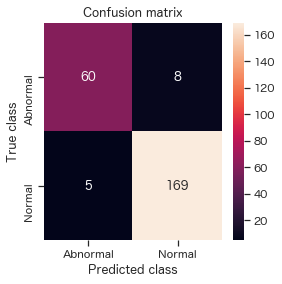

 Accuracy:  0.9462809917355371
 Recall:  0.9712643678160919
 Precision:  0.9548022598870056
 F1 score:  0.9629629629629629


In [935]:
evaluation_metrics(error_df_test_HA35,0.04)

> Accuracy is 95% and Recall is 97% it's Awesome. Let's check for the differenct CPE types.

**For CPE type : W724Ci**

In [707]:
! ls new_lightning_logs/ad_cpe_replacement_autoencoder/W724Ci/version_0/checkpoints

epoch=32-step=1055.ckpt


In [937]:
# ----------------------------------
# to use as embedding extractor
# ----------------------------------
autoencoder_W724Ci = ConvNetAutoEncoder.load_from_checkpoint('new_lightning_logs/ad_cpe_replacement_autoencoder/W724Ci/version_0/checkpoints/epoch=32-step=1055.ckpt')
encoder_model_W724Ci = autoencoder_W724Ci.encoder
encoder_model_W724Ci.eval()

# ----------------------------------
# to use as image generator
# ----------------------------------
decoder_model_W724Ci = autoencoder_W724Ci.decoder
decoder_model_W724Ci.eval()

ConvDecoder(
  (t_conv1): ConvTranspose1d(408, 204, kernel_size=(3,), stride=(2,))
  (t_conv2): ConvTranspose1d(204, 102, kernel_size=(2,), stride=(2,))
  (batch_norm1): BatchNorm1d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=256, out_features=2856, bias=True)
)

### 7.1 Check reconstruction error and losses for Training data

In [938]:
product_class = 'W724Ci'
data_path = "../data/interim/df_train_2.csv"
dataset_W724Ci= ReplacementDataset(data_path, product_class, 'healthy' , scaler=scaler_cpetype)

In [939]:
print('Total AssetIDs in W724Ci:  ',dataset_W724Ci.__len__())

Total AssetIDs in W724Ci:   995


In [940]:
dataset_W724Ci.__getitem__(30)

(tensor(1, dtype=torch.int32),
 tensor([[ 0.0000, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0345, -1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0690,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.9310, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.9655, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000]]))

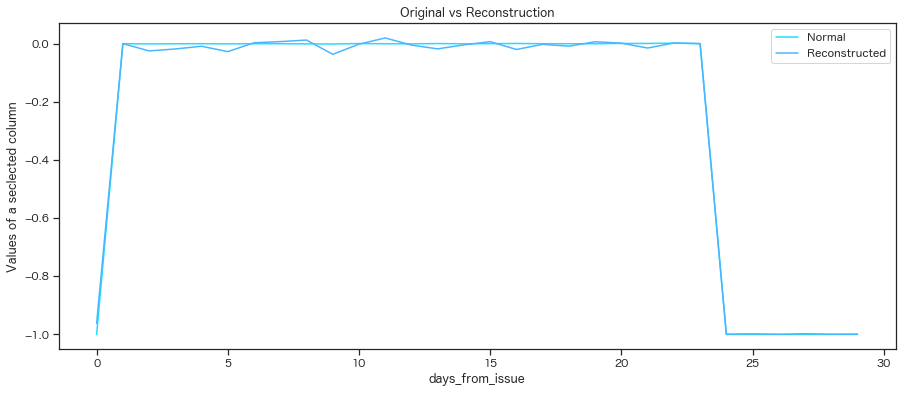

In [941]:
plot_original_reconstruction(dataset_W724Ci,encoder_model_W724Ci,decoder_model_W724Ci,row_num=50,idx_col=25)

In [942]:
losses_W724Ci= summation_loss(dataset_W724Ci,encoder_model_W724Ci,decoder_model_W724Ci)

In [943]:
print(len(losses_W724Ci))
print(min(losses_W724Ci))
print(max(losses_W724Ci))

995
0.0012687486596405506
4.9062676429748535


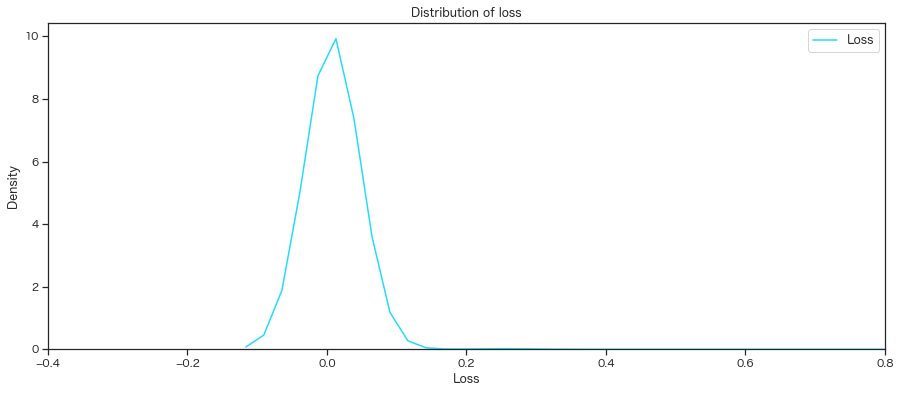

In [949]:
plot_loss_distribution(losses_W724Ci,bins=100,xl=-0.4,xh=0.8)

>For CPE type: W2C4i we can see distribution of losses are getting converged at 0.2. So let's set it as *Threshold* as of now and check for testing set.

### 7.2 Check reconstruction error and losses for Testing data

In [953]:
product_class = 'W724Ci'
data_path = "../data/interim/df_test_2.csv"
dataset_test_W2C4i= ReplacementDataset(data_path, product_class, 'healthy' , scaler=scaler_cpetype)

In [723]:
#df_test.loc[(df_test.cpetype=='HA35-11') & (df_test.CPE_ISSUE=='power_supply')]['assetid'].unique()

array(['86796950', '69423574', '73844330', '41059979', '48257909'],
      dtype=object)

In [954]:
print('Total AssetIDs in W724Ci test set:  ',dataset_test_W2C4i.__len__())

Total AssetIDs in W724Ci test set:   222


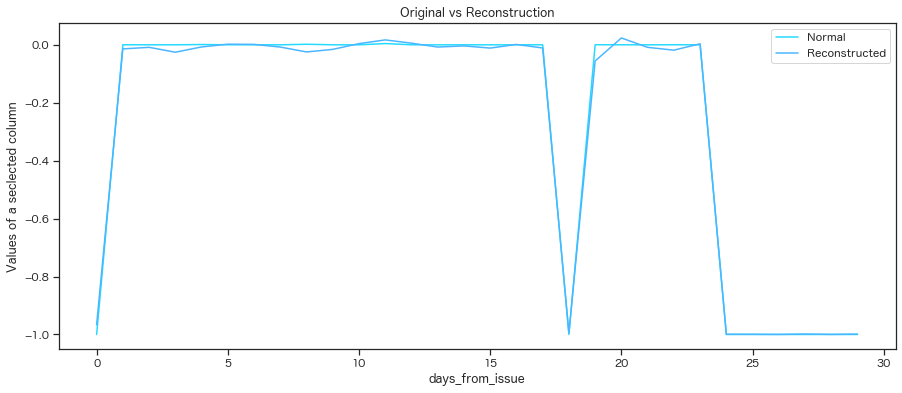

In [955]:
plot_original_reconstruction(dataset_test_W2C4i,encoder_model_W724Ci,decoder_model_W724Ci,row_num=50,idx_col=25)

In [997]:
losses_test_W724Ci = summation_loss(dataset_test_W2C4i,encoder_model_W724Ci,decoder_model_W724Ci)

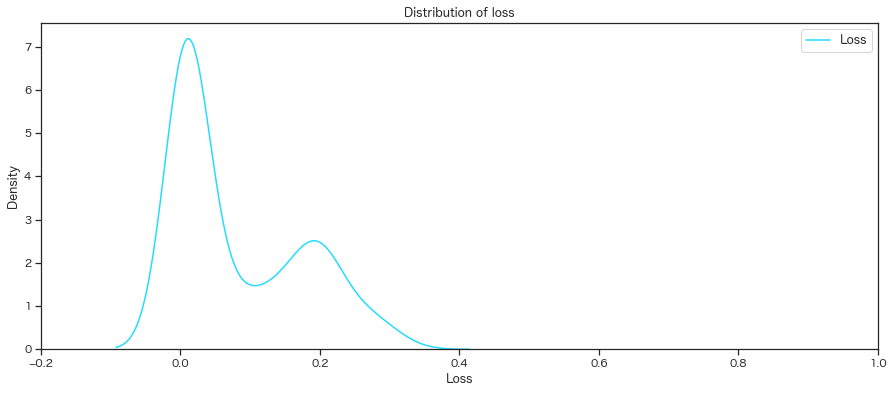

In [998]:
plot_loss_distribution(losses_test_W724Ci,bins=100,xl=-.2,xh=1)

In [959]:
normal_loss,anomaly_loss=separate_losses(dataset_test_Speedport,encoder_model_Speedport,decoder_model_Speedport)

In [960]:
len(normal_loss)

123

In [735]:
#normal_loss

In [961]:
len(anomaly_loss)

99

In [737]:
#anomaly_loss

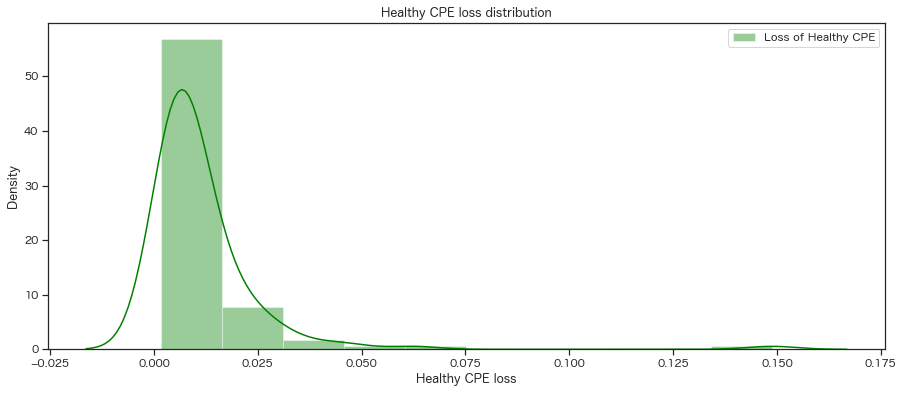

In [964]:
fig = plt.figure(figsize=(15,6))
sns.distplot(normal_loss, bins=10, kde=True,color='green',label='Loss of Healthy CPE')
plt.title('Healthy CPE loss distribution')
plt.xlabel('Healthy CPE loss')
plt.legend()

Text(0.5, 0, 'Anomaly loss')

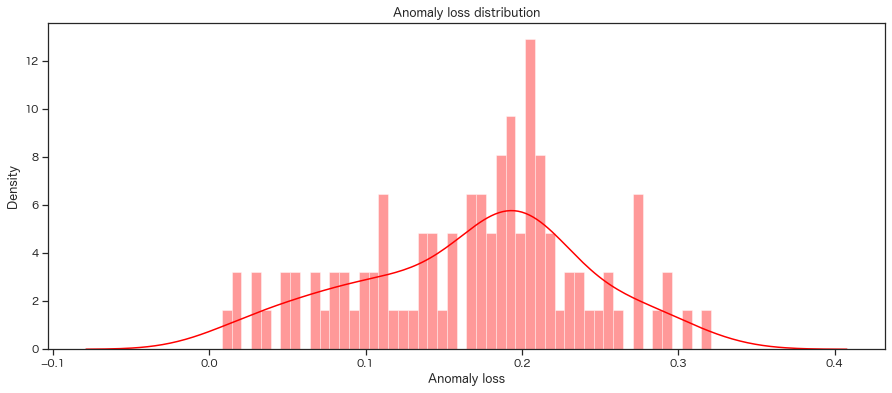

In [971]:
fig = plt.figure(figsize=(15,6))
sns.distplot(anomaly_loss, bins=50, kde=True,color='red',label='Loss of CPE with Anomalies')
plt.title('Anomaly loss distribution')
plt.xlabel('Anomaly loss')

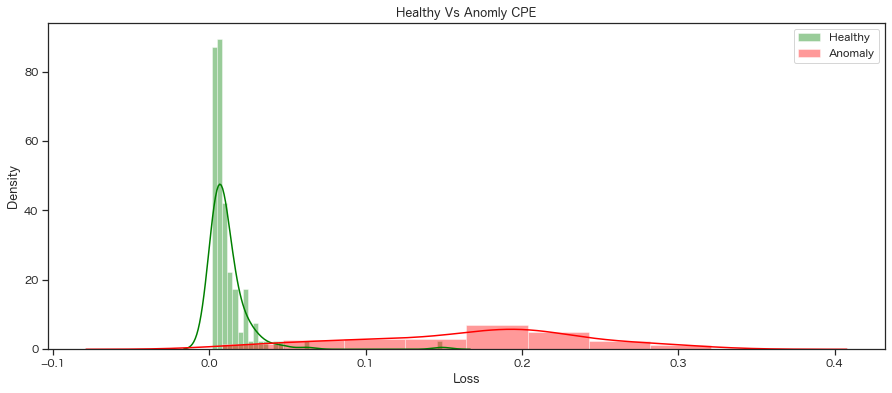

In [967]:
fig = plt.figure(figsize=(15,6))
sns.distplot(normal_loss, kde=True,color='green',label='Healthy')
sns.distplot(anomaly_loss,kde=True,color='red',label='Anomaly')
plt.title('Healthy Vs Anomly CPE')
plt.xlabel('Loss')
plt.legend()
#plt.xlim(-.02,0.1)

>**Insights**
>
>By looking the above graphs we can clear see for Healthy CPEs, distribution of loss is geting converged at 0.075. After that we can see some overlap between the Healthy and Unhealthy CPEs. So we can keep our THRESHOLD=0.04 for separating the CPEs.

## 8. Classifier Stage

### 8.1 CPE type W2C4i- Train Dataset Results

In [972]:
error_df_W724Ci = resultant_df(dataset_W724Ci,encoder_model_W724Ci,decoder_model_W724Ci)
error_df_W724Ci.head()

,Reconstruction_error,Healthy_CPE
0,0.009450,1
1,0.011004,1
2,0.015100,1
3,0.009766,1
4,0.003795,1


In [973]:
error_df_W724Ci.Healthy_CPE.value_counts()

1    995
Name: Healthy_CPE, dtype: int64

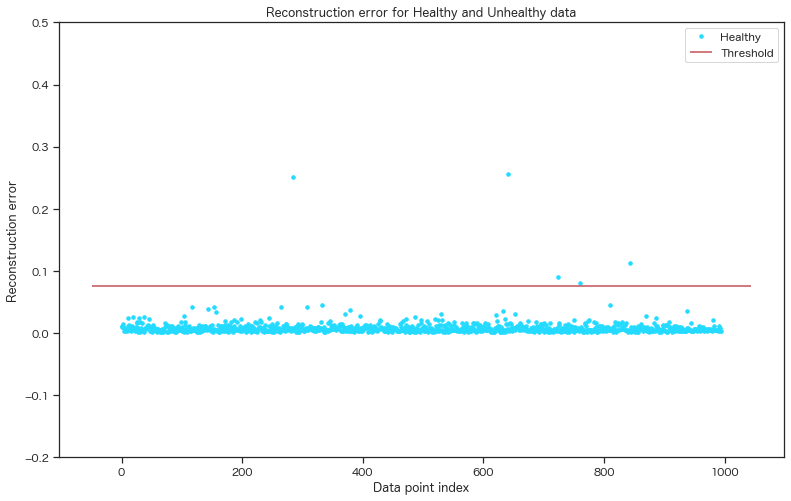

In [977]:
visualize_anomalies(error_df_W724Ci,threshold=0.075,yl=-0.2,yh=0.5)

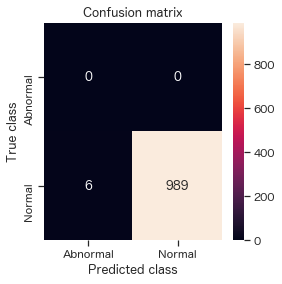

 Accuracy:  0.9939698492462311
 Recall:  0.9939698492462311
 Precision:  1.0
 F1 score:  0.996975806451613


In [978]:
evaluation_metrics(error_df_W724Ci,threshold=0.075)

In [999]:
error_df_W724Ci.head()

,Reconstruction_error,Healthy_CPE,pred
0,0.009450,1,1
1,0.011004,1,1
2,0.015100,1,1
3,0.009766,1,1
4,0.003795,1,1


### 8.2 CPE type W724Ci: Test dataset Results

In [979]:
error_df_test_W724Ci = resultant_df(dataset_test_W2C4i,encoder_model_W724Ci,decoder_model_W724Ci)
error_df_test_W724Ci.head()

,Reconstruction_error,Healthy_CPE
0,0.004599,1
1,0.004677,1
2,0.010647,1
3,0.004068,1
4,0.012955,1


In [981]:
error_df_test_W724Ci.Healthy_CPE.value_counts()

1    123
0     99
Name: Healthy_CPE, dtype: int64

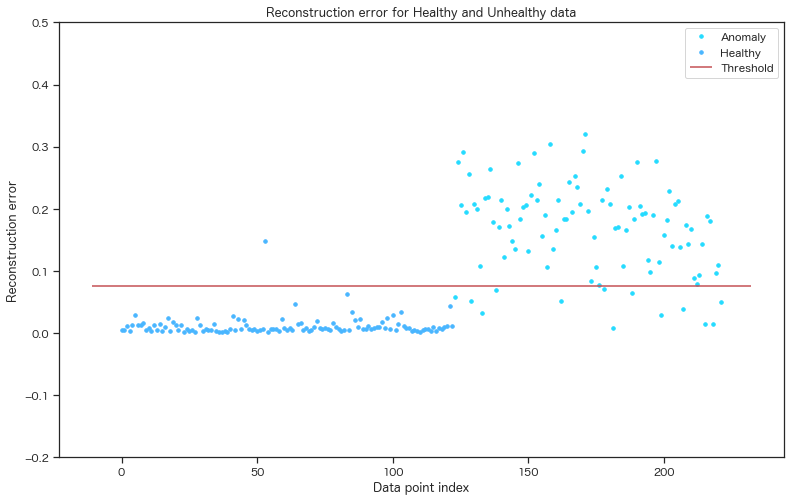

In [982]:
visualize_anomalies(error_df_test_W724Ci,threshold=0.075,yl=-0.2,yh=0.5)

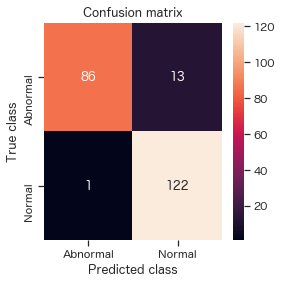

 Accuracy:  0.9369369369369369
 Recall:  0.991869918699187
 Precision:  0.9037037037037037
 F1 score:  0.945736434108527


In [987]:
evaluation_metrics(error_df_test_W724Ci,threshold=0.075)

**For CPE type : Speedport Plus181**

In [1001]:
! ls new_lightning_logs/ad_cpe_replacement_autoencoder/SpeedportPlus181/version_0/checkpoints

epoch=97-step=3821.ckpt


In [1002]:
# ----------------------------------
# to use as embedding extractor
# ----------------------------------
autoencoder_Speedport = ConvNetAutoEncoder.load_from_checkpoint('new_lightning_logs/ad_cpe_replacement_autoencoder/SpeedportPlus181/version_0/checkpoints/epoch=97-step=3821.ckpt')
encoder_model_Speedport = autoencoder_Speedport.encoder
encoder_model_Speedport.eval()

# ----------------------------------
# to use as image generator
# ----------------------------------
decoder_model_Speedport = autoencoder_Speedport.decoder
decoder_model_Speedport.eval()

ConvDecoder(
  (t_conv1): ConvTranspose1d(408, 204, kernel_size=(3,), stride=(2,))
  (t_conv2): ConvTranspose1d(204, 102, kernel_size=(2,), stride=(2,))
  (batch_norm1): BatchNorm1d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=256, out_features=2856, bias=True)
)

### 7.1 Check reconstruction error and losses for Training data

In [1005]:
product_class = 'Speedport Plus181'
data_path = "../data/interim/df_train_2.csv"
dataset_Speedport= ReplacementDataset(data_path, product_class, 'healthy' , scaler=scaler_cpetype)

In [1007]:
print('Total AssetIDs in Speedport:  ',dataset_Speedport.__len__())

Total AssetIDs in Speedport:   1239


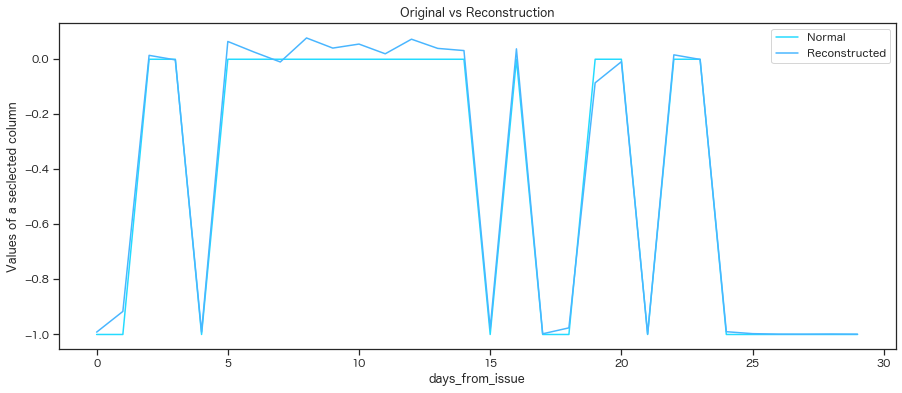

In [1008]:
plot_original_reconstruction(dataset_Speedport,encoder_model_Speedport,decoder_model_Speedport,row_num=50,idx_col=25)

In [1009]:
losses_Speedport= summation_loss(dataset_Speedport,encoder_model_Speedport,decoder_model_Speedport)

In [1010]:
print(len(losses_Speedport))
print(min(losses_Speedport))
print(max(losses_Speedport))

1239
0.0006421207799576223
0.047081079334020615


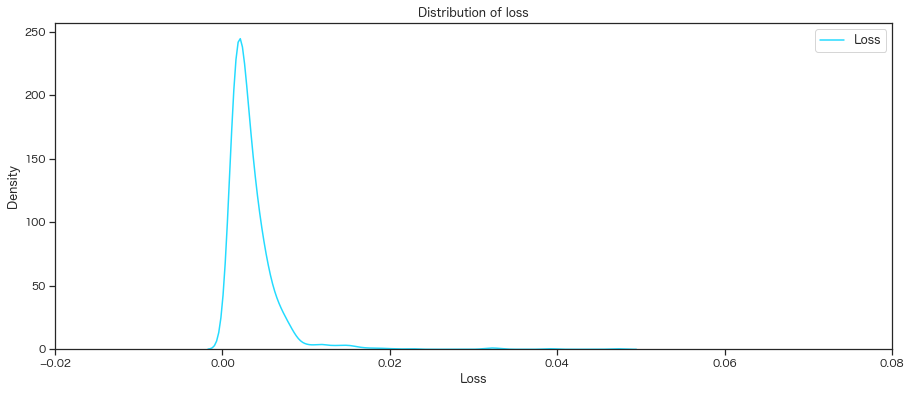

In [1016]:
plot_loss_distribution(losses_Speedport,bins=100,xl=-0.02,xh=0.08)

>For CPE type: W2C4i we can see distribution of losses are getting converged at 0.03. So let's set it as *Threshold* as of now and check for testing set.

### 7.2 Check reconstruction error and losses for Testing data

In [1017]:
product_class = 'Speedport Plus181'
data_path = "../data/interim/df_test_2.csv"
dataset_test_Speedport= ReplacementDataset(data_path, product_class, 'healthy' , scaler=scaler_cpetype)

In [723]:
#df_test.loc[(df_test.cpetype=='HA35-11') & (df_test.CPE_ISSUE=='power_supply')]['assetid'].unique()

array(['86796950', '69423574', '73844330', '41059979', '48257909'],
      dtype=object)

In [1018]:
print('Total AssetIDs in Speed Plus181 test set:  ',dataset_test_Speedport.__len__())

Total AssetIDs in Speed Plus181 test set:   204


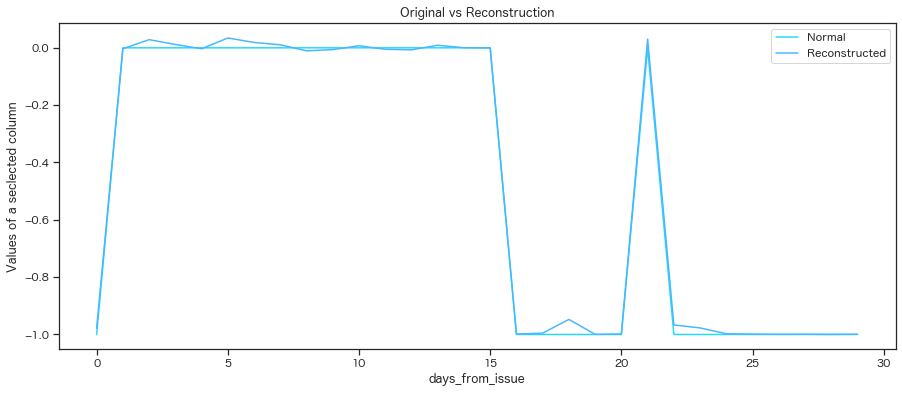

In [1019]:
plot_original_reconstruction(dataset_test_Speedport,encoder_model_Speedport,decoder_model_Speedport,row_num=50,idx_col=25)

In [1020]:
losses_test_Speedport = summation_loss(dataset_test_Speedport,encoder_model_Speedport,decoder_model_Speedport)

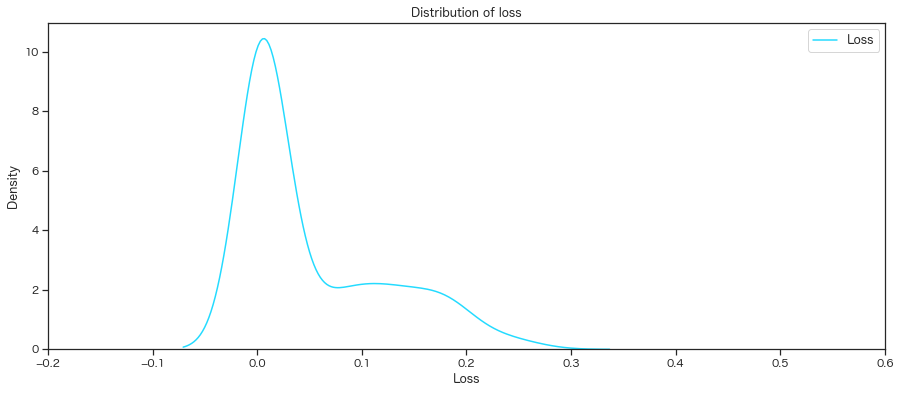

In [1026]:
plot_loss_distribution(losses_test_Speedport,bins=100,xl=-.2,xh=0.6)

In [1027]:
normal_loss,anomaly_loss=separate_losses(dataset_test_Speedport,encoder_model_Speedport,decoder_model_Speedport)

In [1028]:
len(normal_loss)

127

In [1029]:
len(anomaly_loss)

77

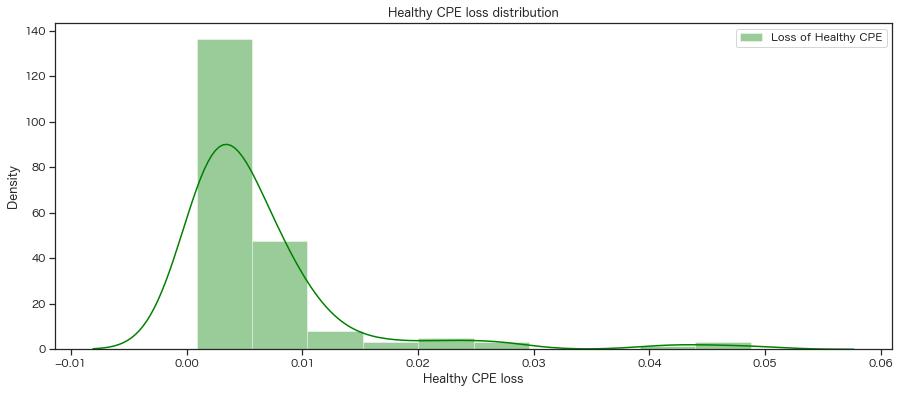

In [1030]:
fig = plt.figure(figsize=(15,6))
sns.distplot(normal_loss, bins=10, kde=True,color='green',label='Loss of Healthy CPE')
plt.title('Healthy CPE loss distribution')
plt.xlabel('Healthy CPE loss')
plt.legend()

Text(0.5, 0, 'Anomaly loss')

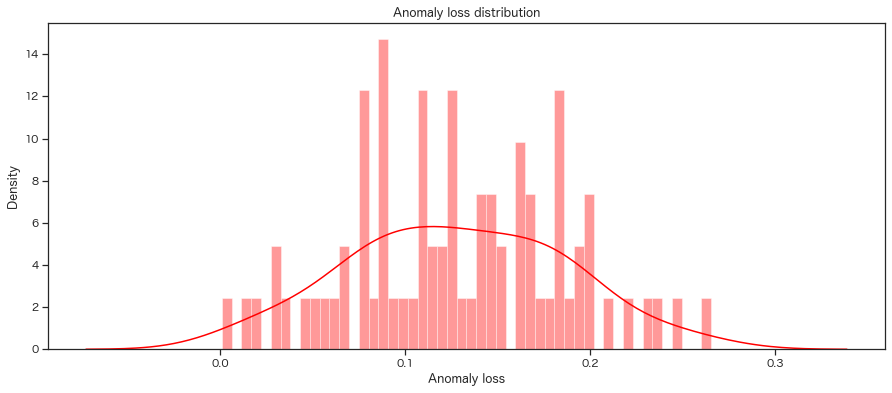

In [1031]:
fig = plt.figure(figsize=(15,6))
sns.distplot(anomaly_loss, bins=50, kde=True,color='red',label='Loss of CPE with Anomalies')
plt.title('Anomaly loss distribution')
plt.xlabel('Anomaly loss')

(-0.1, 0.4)

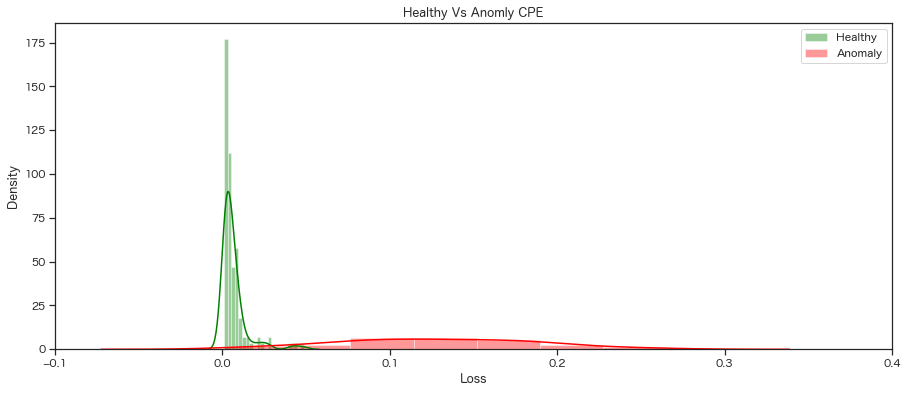

In [1037]:
fig = plt.figure(figsize=(15,6))
sns.distplot(normal_loss, kde=True,color='green',label='Healthy')
sns.distplot(anomaly_loss,kde=True,color='red',label='Anomaly')
plt.title('Healthy Vs Anomly CPE')
plt.xlabel('Loss')
plt.legend()
plt.xlim(-.1,0.4)

>**Insights**
>
>By looking the above graphs we can clear see for Healthy CPEs, distribution of loss is geting converged at 0.03. After that we can see some overlap between the Healthy and Unhealthy CPEs. So we can keep our THRESHOLD=0.03 for separating the CPEs.

## 8. Classifier Stage

### 8.1 CPE type W2C4i- Train Dataset Results

In [1038]:
error_df_Speedport = resultant_df(dataset_Speedport,encoder_model_Speedport,decoder_model_Speedport)
error_df_Speedport.head()

,Reconstruction_error,Healthy_CPE
0,0.002250,1
1,0.001278,1
2,0.001754,1
3,0.001884,1
4,0.003114,1


In [1039]:
error_df_Speedport.Healthy_CPE.value_counts()

1    1239
Name: Healthy_CPE, dtype: int64

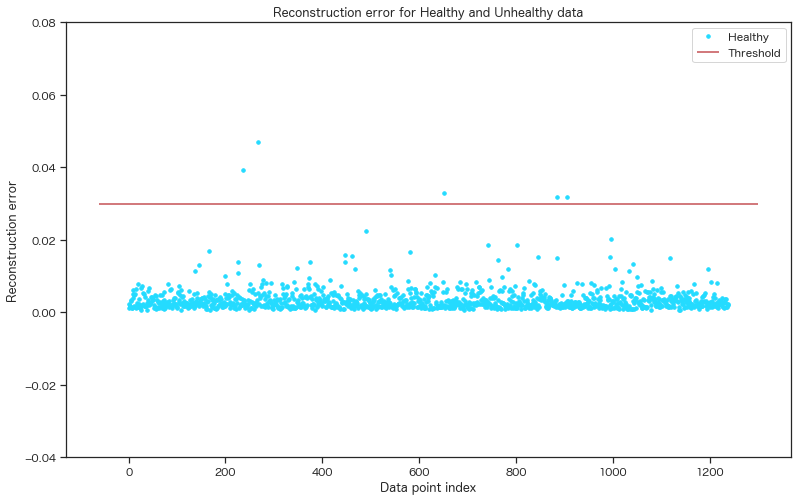

In [1060]:
visualize_anomalies(error_df_Speedport,threshold=0.03,yl=-0.04,yh=0.08)

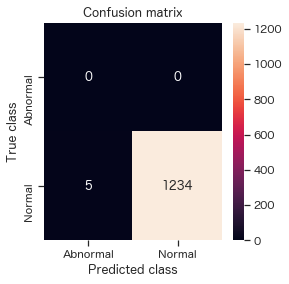

 Accuracy:  0.9959644874899112
 Recall:  0.9959644874899112
 Precision:  1.0
 F1 score:  0.9979781641730692


In [1059]:
evaluation_metrics(error_df_Speedport,threshold=0.03)

In [1044]:
error_df_Speedport.head()

,Reconstruction_error,Healthy_CPE,pred
0,0.002250,1,1
1,0.001278,1,1
2,0.001754,1,1
3,0.001884,1,1
4,0.003114,1,1


### 8.2 CPE type W724Ci: Test dataset Results

In [1045]:
error_df_test_Speedport = resultant_df(dataset_test_Speedport,encoder_model_Speedport,decoder_model_Speedport)
error_df_test_Speedport.head()

,Reconstruction_error,Healthy_CPE
0,0.007834,1
1,0.004774,1
2,0.001001,1
3,0.002905,1
4,0.007190,1


In [1046]:
error_df_test_Speedport.Healthy_CPE.value_counts()

1    127
0     77
Name: Healthy_CPE, dtype: int64

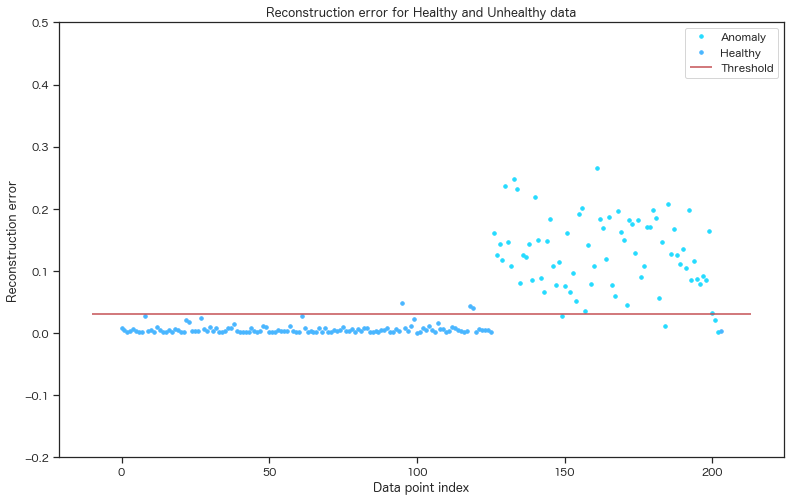

In [1055]:
visualize_anomalies(error_df_test_Speedport,threshold=0.03,yl=-0.2,yh=0.5)

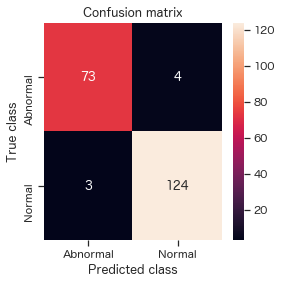

 Accuracy:  0.9656862745098039
 Recall:  0.9763779527559056
 Precision:  0.96875
 F1 score:  0.9725490196078432


In [1058]:
evaluation_metrics(error_df_test_Speedport,threshold=0.03)

# Appendix 

## A. Debuging

In [418]:
window, prediction_gap = 30,1
batch_size = 32
product_class = 'HA35-11'
#data_path = "../data/raw/data_w"+str(window)+"_g"+str(prediction_gap)+"/issues.csv"
data_path = "../data/interim/df_train_2.csv"
dataset = ReplacementDataset(data_path, None, 'healthy', scaler=scaler_cpetype)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)# num_workers=1)


In [419]:
features_dim = 102
window = 30
latent_dim = 256
linear_dim_input = 2604

In [420]:
for i, batch in enumerate(train_loader):
    _,x = batch
    break

In [421]:
x.shape

torch.Size([32, 30, 102])

In [422]:
x_norm = x.permute(0,2,1)


conv1 = nn.Conv1d(in_channels=features_dim, out_channels=2*features_dim, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv1d(in_channels=2*features_dim, out_channels=4*features_dim, kernel_size=3, stride=1, padding=1)
pool = nn.MaxPool1d(2, stride=2)


linear_layer_encode = torch.nn.Linear(linear_dim_input, latent_dim, bias=True)

In [423]:
embedding = F.relu(conv1(x_norm))
embedding = pool(embedding)
embedding = F.relu(conv2(embedding))
embedding = pool(embedding)
embedding = torch.flatten(embedding, start_dim=1)

In [424]:
embedding.shape

torch.Size([32, 2856])

In [861]:

layer_norm= nn.LayerNorm([window])
x_norm = layer_norm(x.permute(0,2,1))


conv1 = nn.Conv1d(in_channels=features_dim, out_channels=2*features_dim, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv1d(in_channels=2*features_dim, out_channels=4*features_dim, kernel_size=3, stride=1, padding=1)
pool = nn.MaxPool1d(2, stride=2)
linear_layer_encode = torch.nn.Linear(linear_dim_input, latent_dim, bias=True)

        

embedding = F.relu(conv1(x_norm))
embedding = pool(embedding)
embedding = F.relu(conv2(embedding))
embedding = pool(embedding)
embedding = torch.flatten(embedding, start_dim=1)


embedding = linear_layer_encode(embedding)

In [862]:
embedding.shape

torch.Size([32, 512])

In [863]:
t_conv1 = nn.ConvTranspose1d(4*features_dim, 2*features_dim, 3, stride=2)
t_conv2 = nn.ConvTranspose1d(2*features_dim, features_dim, 2, stride=2)
linear_layer_decode = torch.nn.Linear(latent_dim, linear_dim_input, bias=True)

x_hat = linear_layer_decode(embedding)



In [864]:
x_hat = x_hat.view(batch_size,4*features_dim,-1)
x_hat = F.relu(t_conv1(x_hat))
x_hat = F.relu(t_conv2(x_hat))

In [865]:
x_hat.shape

torch.Size([32, 93, 30])

In [866]:
x_norm.shape

torch.Size([32, 93, 30])

In [867]:
loss = F.mse_loss(x_hat,x_norm)

In [868]:
loss

tensor(0.5301, grad_fn=<MseLossBackward>)

In [869]:
torch.mean(torch.mean((torch.mean(((x_norm-x_hat)**2),2)),1))

tensor(0.5301, grad_fn=<MeanBackward0>)

# B. Optimal learning rate

In [181]:
from tqdm import tqdm_notebook as tqdm

In [462]:
# Instantiate model
model = ConvNetAutoEncoder()

# Initialize trainer
trainer = pl.Trainer(max_epochs=32, 
                    check_val_every_n_epoch=2, 
                    precision=32)

# It is implemented the built-in function for finding the
# optimal learning rate. Source: https://arxiv.org/pdf/1506.01186.pdf
lr_finder = trainer.tuner.lr_find(model, 
                        min_lr=0.0005, 
                        max_lr=0.005,
                        mode='linear')

# Plots the optimal learning rate
fig = lr_finder.plot(suggest=True)
fig.set_size_inches(18.5, 6, forward=True)
fig.show()


GPU available: False, used: False
TPU available: None, using: 0 TPU cores


MisconfigurationException: No `train_dataloader()` method defined. Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.